# DATA

## Products

- discount: Boolean indicating if the product is on sale.

- embedding: Embedding of the product's flat image obtained from computer vision techniques.

- partnumber: Product identifier.

- color_id: Product color identifier.

- cod_section: Section to which the product belongs.

- familiy: Product family to which the product belongs.

In [4]:
import pandas as pd

# Load the pickle file as a pandas DataFrame
products_df = pd.read_pickle("./data/raw/products.pkl")

# Display the DataFrame
print(products_df.shape)
products_df.head()

(43692, 6)


discount                                          embedding  partnumber  \
0        0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1        0  [-0.0949274, -0.107294075, -0.16559914, -0.174...       41431   
2        0  [-0.12904441, -0.07724628, -0.09799071, -0.164...       39419   
3        1  [-0.12783332, -0.133868, -0.10101265, -0.18888...       36087   
4        1  [-0.14092924, -0.1258284, -0.10809927, -0.1765...       34132   

   color_id  cod_section  family  
0        85          4.0      73  
1       135          4.0      73  
2       339          4.0      73  
3       135          4.0      73  
4         3          4.0      73

## Users

- user_id: User identifier.

- country: Country identifier.

- R: User's recency.

- F: User's purchase frequency.

- M: Monetary value that the customer spends on purchases.

### Obtain data

In [1]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor


In [2]:
def get_all_user_data():
    """
    Fetch user data from the API.

    Args:
        user_id (int): The unique identifier of the user.

    Returns:
        dict: User data as a dictionary or an error message if the request fails.
    """
    # Define the API base URL and endpoint
    base_url = "https://zara-boost-hackathon.nuwe.io"
    endpoint = "/users" 
    
    # Combine base URL and endpoint
    api_url = base_url + endpoint

    try:
        # Make the GET request
        response = requests.get(api_url)

        # Raise an exception for HTTP errors
        response.raise_for_status()

        # Parse and return the JSON response
        return response.json()
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None
    except ValueError:
        print("The response is not valid JSON.")
        return None

In [7]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
# Function to get user data with support for multiple countries
def get_user_data_concurrently(user_id, api_url):
    try:
        response = requests.get(f"{api_url}/{user_id}", timeout=5)  # Set a timeout for each request
        if response.status_code == 200:
            data = response.json()
            user_id = data["user_id"]
            countries = data["values"]["country"]
            Rs = data["values"]["R"]
            Fs = data["values"]["F"]
            Ms = data["values"]["M"]

            # Create one record for each country
            records = [
                {
                    "user_id": user_id,
                    "country": country,
                    "R": R,
                    "F": F,
                    "M": M,
                }
                for country, R, F, M in zip(countries, Rs, Fs, Ms)
            ]

            return records  # Return all records for the user
        else:
            print(f"Failed for user_id {user_id}, status_code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error for user_id {user_id}: {e}")
        return None

# Updated fetch_all_user_data_concurrently
def fetch_all_user_data_concurrently(user_ids, api_url, max_workers=10):
    data_list = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = {executor.submit(get_user_data_concurrently, user_id, api_url): user_id for user_id in user_ids}
        
        # Collect results as they are completed
        for future in futures:
            user_records = future.result()
            if user_records:
                data_list.extend(user_records)  # Add all records for each user

    return pd.DataFrame(data_list)


In [3]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Function to get user data with support for multiple countries
def get_user_data_concurrently(user_id, api_url):
    try:
        response = requests.get(f"{api_url}/{user_id}", timeout=5)  # Set a timeout for each request
        if response.status_code == 200:
            data = response.json()
            user_id = data["user_id"]
            countries = data["values"]["country"]
            Rs = data["values"]["R"]
            Fs = data["values"]["F"]
            Ms = data["values"]["M"]

            # Create one record for each country
            return [
                {
                    "user_id": user_id,
                    "country": country,
                    "R": R,
                    "F": F,
                    "M": M,
                }
                for country, R, F, M in zip(countries, Rs, Fs, Ms)
            ]
        else:
            print(f"Failed for user_id {user_id}, status_code: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error for user_id {user_id}: {e}")
        return []

# Updated fetch function with progress tracking and saving
def fetch_all_user_data_concurrently(user_ids, api_url, output_file="user_data.csv", max_workers=10, save_interval=100):
    data_list = []
    progress = 0
    total_users = len(user_ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_user_data_concurrently, user_id, api_url): user_id for user_id in user_ids}

        for future in as_completed(futures):
            user_records = future.result()
            if user_records:
                data_list.extend(user_records)  # Add all records for each user

            # Update progress
            progress += 1
            print(f"Progress: {progress}/{total_users} users completed", end="\r")

            # Save periodically
            if progress % save_interval == 0 or progress == total_users:
                df = pd.DataFrame(data_list)
                df.to_csv(output_file, index=False)
                print(f"\nData saved to {output_file} at progress: {progress}/{total_users}")

    print("All data fetched successfully!")
    return pd.DataFrame(data_list)


In [9]:
get_user_data_concurrently(555410,base_url)

[{'user_id': 555410, 'country': 25, 'R': 142, 'F': 9, 'M': 57.93000000000001},
 {'user_id': 555410, 'country': 46, 'R': 75, 'F': 1, 'M': 22.95}]

In [ ]:
user_ids = get_all_user_data()    
# Define the API base URL and endpoint
base_url = "https://zara-boost-hackathon.nuwe.io/users"

users_df = fetch_all_user_data_concurrently(user_ids, api_url = base_url, output_file="user_data.csv", max_workers=20, save_interval=50000)

Error for user_id 299077: HTTPSConnectionPool(host='zara-boost-hackathon.nuwe.io', port=443): Read timed out. (read timeout=5)
Error for user_id 524489: ('Connection aborted.', ConnectionResetError(10054, 'Se ha forzado la interrupción de una conexión existente por el host remoto', None, 10054, None))
Error for user_id 54252: ('Connection aborted.', ConnectionResetError(10054, 'Se ha forzado la interrupción de una conexión existente por el host remoto', None, 10054, None))
Error for user_id 40995: ('Connection aborted.', ConnectionResetError(10054, 'Se ha forzado la interrupción de una conexión existente por el host remoto', None, 10054, None))
Error for user_id 523890: HTTPSConnectionPool(host='zara-boost-hackathon.nuwe.io', port=443): Read timed out. (read timeout=5)Progress: 19443/557006 users completed
Error for user_id 373499: HTTPSConnectionPool(host='zara-boost-hackathon.nuwe.io', port=443): Read timed out. (read timeout=5)
Error for user_id 88509: HTTPSConnectionPool(host='zara

In [11]:
len(user_ids)

557006

In [ ]:
users_df.to_csv('users.csv')

In [2]:
import requests
def get_user_data(user_id):
    """
    Fetch user data from the API.

    Args:
        user_id (int): The unique identifier of the user.

    Returns:
        dict: User data as a dictionary or an error message if the request fails.
    """
    # Define the API base URL and endpoint
    base_url = "https://zara-boost-hackathon.nuwe.io"
    endpoint = f"/users/{user_id}"  # Format the endpoint with the user_id
    
    # Combine base URL and endpoint
    api_url = base_url + endpoint

    try:
        # Make the GET request
        response = requests.get(api_url)

        # Raise an exception for HTTP errors
        response.raise_for_status()

        # Parse and return the JSON response
        return response.json()
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None
    except ValueError:
        print("The response is not valid JSON.")
        return None

# Example usage
if __name__ == "__main__":
    user_id = 555410  # Replace with the desired user_id
    user_data = get_user_data(user_id)
    
    if user_data:
        print("User Data Retrieved:")
        print(user_data)


User Data Retrieved:
{'user_id': 555410, 'values': {'country': [25, 46], 'R': [142, 75], 'F': [9, 1], 'M': [57.93000000000001, 22.95]}}


In [18]:
len(get_all_user_data())

557006

In [6]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor

# Function to get user data
def get_user_data_concurrently(user_id, api_url):
    try:
        response = requests.get(f"{api_url}/{user_id}", timeout=5)  # Set a timeout for each request
        if response.status_code == 200:
            data = response.json()
            return {
                "user_id": data["user_id"],
                "country": data["values"]["country"][0],  # Assuming the first value
                "R": data["values"]["R"][0],
                "F": data["values"]["F"][0],
                "M": data["values"]["M"][0],
            }
        else:
            print(f"Failed for user_id {user_id}, status_code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error for user_id {user_id}: {e}")
        return None

# Main function to fetch data concurrently
def fetch_all_user_data_concurrently(user_ids, api_url, max_workers=10):
    data_list = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = {executor.submit(get_user_data_concurrently, user_id, api_url): user_id for user_id in user_ids}
        
        # Collect results as they are completed
        for future in futures:
            user_data = future.result()
            if user_data:
                data_list.append(user_data)

    return pd.DataFrame(data_list)



In [22]:
user_df = pd.read_csv('users.csv')
user_list = users_df['user_id'].values.tolist()  # Renamed 'list' to 'user_list' to avoid shadowing built-in list
print(len(user_list))

user_set = set(user_list)  # Renamed 'set' to 'user_set'
user_ids = get_all_user_data()
print(len(user_ids))

filtered_list = [item for item in user_ids if item not in user_set]
print(len(filtered_list))


557006
557006
0


In [8]:
api_url = "https://zara-boost-hackathon.nuwe.io/users"  # Replace with your API URL

# Fetch data
user_df1 = fetch_all_user_data_concurrently(filtered_list, api_url, max_workers=20)  # Increase workers for more concurrency

In [7]:
#user_df = pd.DataFrame(data_list)
user_df.to_csv('users2.csv')

In [9]:
user_df1

user_id  country    R    F           M
0    293316       25   26   19  123.529474
1    381400       25   12  120   24.951529
2    381401       25    1   74   65.638750
3    381403       25   24   26   15.405556
4    381404       25    0   68   52.440000
5    381405       25   14   22   21.684783
6    381406       25   17   28   62.886667
7    381407       25    1   57   65.292154
8    381408       25   14   36   95.331111
9    381409       25    4   37   18.281552
10   381410       25   39   30   48.007813
11   381411       25    9   33   64.138718
12   381412       25   30   33   31.727619
13   381413       25    1   32   24.533830
14   161371       25    3   48   29.615070
15   451318       25  147   11   27.390833
16   489880       25  130    5   26.824286
17   441457       25   24   64   30.668060
18     3329       25   37   47   34.341129

### Read Data

In [1]:
import pandas as pd
user_df = pd.read_csv('./data/processed/users.csv')
user_df

country    R    F           M  user_id
0            25    5   11   31.578182   540122
1            25    1  197   13.540806   419732
2            25    9    5   67.646000   255950
3            25   18   27   17.238293   502051
4            25   81    1  106.825000   134790
...         ...  ...  ...         ...      ...
577489       25   12   52   67.162727   239636
577490       25  136   20   30.600800   434411
577491       25    0   88   39.129576   287192
577492       25   35   14   34.296429   325975
577493       25    1   20   56.330476   481676

[577494 rows x 5 columns]

## Train/Test

- session_id: Session identifier.

- date: Interaction date.

- timestamp_local: Interaction timestamp.

- user_id: User identifier.

- country: Country identifier.

- partnumber: Product identifier with which the interaction occurred.

- device_type: Type of device used.

- pagetype: Type of page where the interaction occurred within the e-commerce site.

- add_to_cart: Boolean indicating if the interaction was adding to the cart. This variable won't be available in the test dataset.

In [2]:
import pandas as pd
train_df = pd.read_csv("./data/raw/train.csv")
train_df['timestamp_local'] = pd.to_datetime(train_df['timestamp_local'])
train_df

session_id        date         timestamp_local  add_to_cart  \
0                 64  2024-06-06 2024-06-06 16:43:17.389            0   
1                117  2024-06-08 2024-06-08 15:11:02.782            0   
2                117  2024-06-08 2024-06-08 15:11:44.797            0   
3                579  2024-06-05 2024-06-05 19:24:48.397            0   
4               1220  2024-06-04 2024-06-04 08:21:13.476            0   
...              ...         ...                     ...          ...   
46551440     5170695  2024-06-07 2024-06-07 17:57:24.644            0   
46551441     5171109  2024-06-04 2024-06-04 12:34:05.430            0   
46551442     5171307  2024-06-07 2024-06-07 07:50:02.549            0   
46551443     5171603  2024-06-13 2024-06-13 17:56:44.477            0   
46551444     5171698  2024-06-11 2024-06-11 03:05:21.361            0   

           user_id  country  partnumber  device_type  pagetype  
0              NaN       29       14327            1      24.0  
1              NaN       57       38422            1      24.0  
2              NaN       57       19763            1      24.0  
3              NaN       29       30253            1      24.0  
4         480729.0       25        1592            1      24.0  
...            ...      ...         ...          ...       ...  
46551440       NaN       34       39901            3      24.0  
46551441       NaN       29       38638            1      24.0  
46551442       NaN       25       10883            1      24.0  
46551443       NaN       29        3769            1      24.0  
46551444       NaN       34       37323            1      24.0  

[46551445 rows x 9 columns]

In [3]:
import pandas as pd
test_df = pd.read_csv("./data/raw/test.csv")
test_df['timestamp_local'] = pd.to_datetime(test_df['timestamp_local'])
test_df['add_to_cart'] = -1
test_df=test_df[['session_id', 'date', 'timestamp_local', 'add_to_cart', 'user_id',
       'country', 'partnumber', 'device_type', 'pagetype']]
test_df
#test_df[~test_df['user_id'].isna()]

session_id        date         timestamp_local  add_to_cart  user_id  \
0             746  2024-06-15 2024-06-15 18:36:47.390           -1      NaN   
1             746  2024-06-15 2024-06-15 18:37:04.052           -1      NaN   
2             746  2024-06-15 2024-06-15 18:37:48.159           -1      NaN   
3             746  2024-06-15 2024-06-15 18:38:19.899           -1      NaN   
4             746  2024-06-15 2024-06-15 18:38:46.492           -1      NaN   
...           ...         ...                     ...          ...      ...   
29270     5167195  2024-06-16 2024-06-16 13:13:10.152           -1      NaN   
29271     5167272  2024-06-16 2024-06-16 18:58:15.562           -1      NaN   
29272     5168338  2024-06-15 2024-06-15 21:36:15.931           -1      NaN   
29273     5168492  2024-06-16 2024-06-16 04:06:03.528           -1      NaN   
29274     5168933  2024-06-16 2024-06-16 04:53:26.427           -1      NaN   

       country  partnumber  device_type  pagetype  
0           57        1254            1      24.0  
1           57       32544            1      24.0  
2           57       12639            1      24.0  
3           57       18048            1      24.0  
4           57       13295            1      24.0  
...        ...         ...          ...       ...  
29270       34       30113            1      24.0  
29271       34       28922            1       8.0  
29272       34       13467            1      24.0  
29273       34       13732            1      24.0  
29274       57        8969            1      24.0  

[29275 rows x 9 columns]

# Task 1

## Q1: Which product (partnumber) with color_id equal to 3 belongs to the lowest familiy code with a discount?

In [11]:
df1 = train_df[(train_df['color_id'] == 3) & (train_df['discount'] == 1)]
df1.sort_values(by=['family']).head()


discount                                          embedding  partnumber  \
19413        1  [-0.16633523, -0.13765946, 0.31306392, -0.1556...       17265   
7192         1  [-0.0348624, -0.15140663, -0.14670782, -0.1560...       41826   
25034        1  [-0.16127115, -0.103424996, -0.05674305, -0.16...       24756   
22987        1  [-0.13689718, -0.16824937, -0.05676314, -0.163...       22971   
22218        1  [0.11410374, -0.020614242, -0.10820875, -0.129...       27137   

       color_id  cod_section  family  
19413         3          4.0       1  
7192          3          1.0       6  
25034         3          1.0       6  
22987         3          1.0       6  
22218         3          3.0       6

## Q2: In the country where most users have made purchases totaling less than 500 (M) , which is the user who has the lowest purchase frequency (F), the most recent purchase (highest R) and the lowest user_id? Follow the given order of variables as the sorting priority.

In [34]:
df1 = users_df
df1['500'] = 0
df1.loc[df1['M']<500,'500']=1
pd.pivot_table(df1, index = 'country', aggfunc='count', values='500').sort_values(by='500', ascending = False).head()

500
country        
25       547028
46         1532
13         1137
39          865
20          812

In [32]:
df1 = users_df[users_df['country'] == 25]
df1.sort_values(by=['F','R','user_id'], ascending=[True,False,True])

user_id  country     R      F           M  500
48437    187374       25  1095      0    0.000000    1
251843   378191       25  1095      0    0.000000    1
91283    501520       25  1093      0    0.000000    1
91139    520478       25  1092      0    0.000000    1
115788   531378       25  1089      0    0.000000    1
...         ...      ...   ...    ...         ...  ...
319973   191303       25     0   4282   69.009922    1
207550    80586       25     0   4457  127.059209    1
50418    489327       25     0   5870   85.132453    1
98349     72153       25     0  10650  193.883441    1
343667   228139       25     0  10754   85.199916    1

[547028 rows x 6 columns]

## Q3: Among the products that were added to the cart at least once, how many times is a product visited before it is added to the cart in average? Give the answer with 2 decimals.

In [49]:
import pandas as pd
import numpy as np

def calculate_visits_per_purchase(train_df):
    # Step 1: Filter rows where a product was added to the cart
    purchases = train_df[train_df['add_to_cart'] > 0]
    
    # Step 2: Get the max purchase timestamp for each (session_id, partnumber) pair
    max_purchase_times = purchases.groupby(['session_id', 'partnumber'])['timestamp_local'].max().reset_index()
    max_purchase_times.rename(columns={'timestamp_local': 'max_purchase_time'}, inplace=True)

    # Step 3: Merge the max purchase times back to the original dataframe
    train_df = train_df.merge(max_purchase_times, on=['session_id', 'partnumber'], how='left')

    # Step 4: Filter rows up to the max purchase timestamp
    filtered_df = train_df[train_df['timestamp_local'] <= train_df['max_purchase_time']]

    # Step 5: Group by (session_id, partnumber) to calculate total visits and purchases
    visit_purchase_summary = filtered_df.groupby(['session_id', 'partnumber']).agg(
        total_visits=('timestamp_local', 'count'),
        total_purchases=('add_to_cart', 'sum')
    ).reset_index()

    # Step 6: Calculate visits per purchase for each pair
    visit_purchase_summary['visits_per_purchase'] = (
        visit_purchase_summary['total_visits'] / visit_purchase_summary['total_purchases']
    )

    # Step 7: Calculate the overall average
    overall_average = visit_purchase_summary['visits_per_purchase'].mean()
    print(f"The overall average number of visits per purchase is: {overall_average:.2f}")

    # Step 8: Return the result for further analysis (if needed)
    return visit_purchase_summary

calculate_visits_per_purchase(train_df)

The overall average number of visits per purchase is: 1.33


session_id  partnumber  total_visits  total_purchases  \
0                10       35936             1                1   
1                24        1413             1                1   
2                24        7889             1                1   
3                24       18424             3                1   
4                24       29751             1                1   
...             ...         ...           ...              ...   
2634355     5171828        7115             1                1   
2634356     5171837        2867             1                1   
2634357     5171837        3184             2                1   
2634358     5171842        9466             1                1   
2634359     5171847        6250             1                1   

         visits_per_purchase  
0                        1.0  
1                        1.0  
2                        1.0  
3                        3.0  
4                        1.0  
...                      ...  
2634355                  1.0  
2634356                  1.0  
2634357                  2.0  
2634358                  1.0  
2634359                  1.0  

[2634360 rows x 5 columns]

In [50]:
import pandas as pd
import numpy as np

def calculate_visits_per_purchase(train_df):
    # Step 1: Filter rows where a product was added to the cart
    purchases = train_df[train_df['add_to_cart'] > 0]
    
    # Step 2: Get the max purchase timestamp for each (session_id, partnumber) pair
    max_purchase_times = purchases.groupby(['session_id', 'partnumber'])['timestamp_local'].max().reset_index()
    max_purchase_times.rename(columns={'timestamp_local': 'max_purchase_time'}, inplace=True)

    # Step 3: Merge the max purchase times back to the original dataframe
    train_df = train_df.merge(max_purchase_times, on=['session_id', 'partnumber'], how='left')

    # Step 4: Filter rows up to the max purchase timestamp
    filtered_df = train_df[train_df['timestamp_local'] <= train_df['max_purchase_time']]

    # Step 5: Group by (session_id, partnumber) to calculate total visits and purchases
    visit_purchase_summary = filtered_df.groupby(['session_id', 'partnumber']).agg(
        total_visits=('timestamp_local', 'count'),
        total_purchases=('add_to_cart', 'sum')
    ).reset_index()

    # Step 6: Calculate visits per purchase for each pair
    visit_purchase_summary['visits_per_purchase'] = (
        visit_purchase_summary['total_visits'] / visit_purchase_summary['total_purchases']
    )

    # Step 7: Calculate the overall average in two ways
    # Method 1: By averaging the `visits_per_purchase` column
    average_by_pairs = visit_purchase_summary['visits_per_purchase'].mean()

    # Method 2: By summing total visits and purchases and dividing
    total_visits = visit_purchase_summary['total_visits'].sum()
    total_purchases = visit_purchase_summary['total_purchases'].sum()
    overall_average = total_visits / total_purchases

    # Step 8: Print results
    print(f"Average by pairs: {average_by_pairs:.2f}")
    print(f"Overall average (summed totals): {overall_average:.2f}")

    # Step 9: Return the summary DataFrame for further analysis
    return visit_purchase_summary

calculate_visits_per_purchase(train_df)

Average by pairs: 1.33
Overall average (summed totals): 1.34


session_id  partnumber  total_visits  total_purchases  \
0                10       35936             1                1   
1                24        1413             1                1   
2                24        7889             1                1   
3                24       18424             3                1   
4                24       29751             1                1   
...             ...         ...           ...              ...   
2634355     5171828        7115             1                1   
2634356     5171837        2867             1                1   
2634357     5171837        3184             2                1   
2634358     5171842        9466             1                1   
2634359     5171847        6250             1                1   

         visits_per_purchase  
0                        1.0  
1                        1.0  
2                        1.0  
3                        3.0  
4                        1.0  
...                      ...  
2634355                  1.0  
2634356                  1.0  
2634357                  2.0  
2634358                  1.0  
2634359                  1.0  

[2634360 rows x 5 columns]

In [11]:
import pandas as pd

# Step 1: Filter out rows with NaN in user_id
df1= train_df[~train_df['user_id'].isna()]

# Step 2: Filter for products that were added to the cart at least once
added_to_cart_products = train_df[train_df['add_to_cart'] > 0]['partnumber'].unique()

# Step 3: Filter the dataset to only include interactions with those products
filtered_df = df1[df1['partnumber'].isin(added_to_cart_products)]

# Step 4: Group by user_id and partnumber to calculate visits and add_to_cart for each product per user
grouped = filtered_df.groupby(['user_id', 'partnumber']).agg(
    visits=('partnumber', 'count'),          # Count of visits
    purchases=('add_to_cart', 'sum')        # Count of add_to_cart actions
)

# Step 5: Only keep products that were added to the cart at least once
grouped = grouped[grouped['purchases'] > 0]

# Step 6: Calculate the average number of visits before a product is added to the cart
average_visits_per_add_to_cart = (grouped['visits'] / grouped['purchases']).mean()

# Print the result rounded to 2 decimals
print(round(average_visits_per_add_to_cart, 2))


1.87


In [10]:
df1 = pd.pivot_table(train_df, index='partnumber', aggfunc='sum', values='add_to_cart')
df1 = df1[df1['add_to_cart']>0]
atleast1 = df1['add_to_cart'].values.tolist()

df1 = train_df[train_df['partnumber'].isin(atleast1)]

#we can only count across several sessions for registered users
df1 = df1[~df1['user_id'].isna()]

#count the visits and purchases of each user for an item
df2 = df1.groupby(['user_id','partnumber']).agg(
    visits=('partnumber', 'count'),
    purchases = ('add_to_cart', 'sum')
)
df2 = df2[df2['purchases']>0]
ratio = (df2['visits']/df2['purchases']).mean()
print(ratio.round(2))

1.9


In [12]:
# Step 1: Filter products that were added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]

# Step 2: Get the list of product IDs (partnumbers) that were added to the cart
products_added = added_to_cart['partnumber'].unique()

# Step 3: Filter the original dataframe for visits of these products
df1 = train_df[train_df['partnumber'].isin(products_added)]

# Count the occurrences of each partnumber
value_counts = df1['partnumber'].value_counts()

# Create a pivot table to sum the 'add_to_cart' values for each partnumber
add_to_cart_sum = pd.pivot_table(
    df1, index='partnumber', values='add_to_cart', aggfunc='sum'
)

# Combine both into a single DataFrame
df1 = pd.DataFrame({
    'visits': value_counts,
    'add_to_cart_sum': add_to_cart_sum['add_to_cart']
})

# Reset the index if you want 'partnumber' as a column
df1.reset_index(inplace=True)

# Rename columns for clarity (optional)
df1.rename(columns={'index': 'partnumber'}, inplace=True)

avg = (df1['visits']/df1['add_to_cart_sum']).mean()
print(avg)



23.68712686232947


In [27]:
# Step 1: Filter products that were added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]

# Step 2: Get the list of product IDs (partnumbers) that were added to the cart
products_added = added_to_cart['partnumber'].unique()

# Step 3: Filter the original dataframe for visits of these products
df1 = train_df[train_df['partnumber'].isin(products_added)]

# Step 4: Count the number of visits for each product
visit_counts = df1['partnumber'].value_counts()

# Step 5: Sum the 'add_to_cart' values for each product
add_to_cart_sum = added_to_cart.groupby('partnumber')['add_to_cart'].sum()

# Step 6: Combine into a single DataFrame
df1 = pd.DataFrame({
    'visits': visit_counts,
    'add_to_cart_sum': add_to_cart_sum
})

# Step 7: Calculate the average number of visits per add-to-cart
df1['visits_per_add_to_cart'] = df1['visits'] / df1['add_to_cart_sum']
average_visits_per_add = df1['visits_per_add_to_cart'].mean()

# Step 8: Print the result with 2 decimals
print(f"{average_visits_per_add:.2f}")


23.69


In [42]:
# Step 1: Filter products that were added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]

# Step 2: Get the list of product IDs (partnumbers) that were added to the cart
products_added = added_to_cart['partnumber'].unique()

# Step 3: Filter the original dataframe for visits of these products
df1 = train_df[train_df['partnumber'].isin(products_added)]

# Step 4: Count the occurrences of each partnumber (total visits)
value_counts = df1['partnumber'].value_counts()

# Step 5: Create a pivot table to sum the 'add_to_cart' values for each partnumber
add_to_cart_sum = pd.pivot_table(
    df1, index='partnumber', values='add_to_cart', aggfunc='sum'
)

# Step 6: Combine both into a single DataFrame
df1 = pd.DataFrame({
    'visits': value_counts,
    'add_to_cart_sum': add_to_cart_sum['add_to_cart']
})

# Step 7: Calculate the overall average visits per add-to-cart event
total_visits = df1['visits'].sum()
total_add_to_cart = df1['add_to_cart_sum'].sum()

average_visits_per_add_to_cart = total_visits / total_add_to_cart

# Print the result with 2 decimal places
print(f"{average_visits_per_add_to_cart:.2f}")


16.90


In [48]:
df1 = pd.pivot_table(train_df, index='partnumber', aggfunc='sum', values='add_to_cart')
df1 = pd.pivot_table(train_df, index='partnumber', aggfunc='count', values='partnumber')
df1 = df1[df1['add_to_cart']>0]
atleast1 = df1['add_to_cart'].values.tolist()
atleast1

[140,
 308,
 98,
 34,
 744,
 3,
 234,
 1,
 58,
 315,
 63,
 64,
 4,
 85,
 1,
 18,
 106,
 153,
 3,
 178,
 126,
 108,
 30,
 1,
 1,
 2,
 383,
 1055,
 265,
 6,
 7,
 127,
 7,
 381,
 9,
 811,
 2,
 5,
 10,
 147,
 125,
 133,
 527,
 17,
 310,
 455,
 586,
 217,
 198,
 525,
 33,
 9,
 3,
 140,
 35,
 13,
 429,
 60,
 65,
 32,
 18,
 183,
 115,
 137,
 26,
 8,
 48,
 5,
 292,
 24,
 113,
 922,
 276,
 44,
 20,
 31,
 58,
 59,
 16,
 44,
 105,
 13,
 2,
 129,
 20,
 38,
 114,
 74,
 3,
 55,
 7,
 47,
 1,
 49,
 57,
 1,
 102,
 118,
 1567,
 54,
 5,
 2,
 1,
 364,
 65,
 11,
 1,
 13,
 13,
 1058,
 3,
 2,
 4,
 26,
 218,
 162,
 10,
 8,
 73,
 4,
 255,
 45,
 29,
 836,
 13,
 7,
 9,
 41,
 51,
 630,
 10,
 1,
 3,
 26,
 10,
 1,
 22,
 4,
 9,
 2,
 2,
 1,
 4,
 2,
 9,
 14,
 9,
 1,
 3,
 2,
 4,
 1,
 2,
 9,
 1,
 3,
 2,
 2,
 3,
 26,
 1,
 11,
 201,
 10,
 167,
 23,
 39,
 210,
 26,
 3,
 1752,
 1,
 285,
 6,
 30,
 16,
 152,
 75,
 47,
 153,
 35,
 224,
 9,
 19,
 120,
 157,
 147,
 70,
 49,
 69,
 86,
 8,
 20,
 6,
 65,
 17,
 173,
 8,
 6,
 65,
 36

In [55]:
df1 = train_df[train_df['partnumber'].isin(atleast1)]

metrics = df1.groupby(['session_id', 'partnumber']).agg(
    visits=('partnumber', 'count'),
    purchase=('add_to_cart', 'sum'))
metrics = metrics[metrics['purchase'] != 0]
metrics['visits'].mean().round(2)

np.float64(1.93)

In [13]:
# Step 1: Filter for rows with NaN user IDs
train_df = train_df[~train_df['user_id'].isna()]

# Step 2: Filter products that were added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]

# Step 3: Get the list of product IDs (partnumbers) that were added to the cart
products_added = added_to_cart['partnumber'].unique()

# Step 4: Filter the original dataset to include only these products
filtered_df = train_df[train_df['partnumber'].isin(products_added)]

# Step 5: Group by user_id and partnumber to calculate visits and add_to_cart for each user-product pair
grouped = filtered_df.groupby(['user_id', 'partnumber']).agg(
    visits=('partnumber', 'count'),          # Count the number of visits
    add_to_cart=('add_to_cart', 'sum')      # Sum of add_to_cart actions
)

# Step 6: Filter out rows where no add-to-cart actions occurred
grouped = grouped[grouped['add_to_cart'] > 0]

# Step 7: Calculate the ratio of visits to add-to-cart for each user-product pair
grouped['visits_per_add_to_cart'] = grouped['visits'] / grouped['add_to_cart']

# Step 8: Compute the overall average
average_visits_per_add_to_cart = grouped['visits_per_add_to_cart'].mean()

# Print the result with 2 decimal places
print(f"{average_visits_per_add_to_cart:.2f}")


1.87


In [14]:
import pandas as pd

# Step 1: Filter for products added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]
products_added = added_to_cart['partnumber'].unique()

# Step 2: Filter the dataset to include only interactions with these products
filtered_df = train_df[train_df['partnumber'].isin(products_added)]

# Step 3: Sort data by user_id, partnumber, and timestamp
filtered_df = filtered_df.sort_values(by=['user_id', 'partnumber', 'timestamp_local'])

# Step 4: Calculate visits before the first add-to-cart for each user-product pair
def calculate_visits_before_cart(group):
    """
    For each user-product group, count visits before the first add-to-cart.
    """
    add_to_cart_indices = group.index[group['add_to_cart'] > 0].tolist()
    if add_to_cart_indices:
        first_cart_index = add_to_cart_indices[0]
        return first_cart_index  # Visits before the first add-to-cart
    else:
        return None

# Group by user_id and partnumber, then apply the function
filtered_df['visit_count'] = 1  # Add a column to count visits
grouped = filtered_df.groupby(['user_id', 'partnumber']).apply(calculate_visits_before_cart).reset_index(name='visits_before_cart')

# Step 5: Filter out user-product pairs where no add-to-cart action occurred
grouped = grouped[~grouped['visits_before_cart'].isna()]

# Step 6: Compute the average visits before add-to-cart
average_visits_before_cart = grouped['visits_before_cart'].mean()

# Print the result rounded to 2 decimals
print(f"{average_visits_before_cart:.2f}")


23389874.22


C:\Users\afred\AppData\Local\Temp\ipykernel_16552\567421960.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = filtered_df.groupby(['user_id', 'partnumber']).apply(calculate_visits_before_cart).reset_index(name='visits_before_cart')


In [18]:
# Step 1: Filter products that were added to the cart at least once
added_to_cart = train_df[train_df['add_to_cart'] > 0]

# Step 2: Get the first time each product was added to the cart
products_added = added_to_cart.groupby('partnumber').agg(
    first_purchase=('timestamp_local', 'min')  # Earliest add-to-cart timestamp for each product
).reset_index()

# Step 3: Filter the original dataset to include only interactions with these products
filtered_df = train_df[train_df['partnumber'].isin(products_added['partnumber'].unique())]

# Step 4: Calculate the total number of visits before the first add-to-cart for each product
visits = 0
i=0
for row in products_added.itertuples():
    product = row.partnumber
    first_purchase = row.first_purchase

    # Count visits for this product that occurred before the first add-to-cart
    visits += filtered_df[(filtered_df['partnumber'] == product) & 
                          (filtered_df['timestamp_local'] < first_purchase)].shape[0]
    i+=1
    print(i)
# Step 5: Calculate the average visits per product before the first add-to-cart
average_visits = visits / len(products_added['partnumber'].unique())

# Print the result rounded to 2 decimals
print(f"{average_visits:.2f}")



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
#filtered_df = train_df[train_df['partnumber'].isin(products_added)]

29107

## Q4: Which device (device_type) is most frequently used by users to make purchases (add_to_cart = 1) of discounted products (discount = 1)?

In [43]:
df1 = train_df[train_df['add_to_cart']==1]
df1 = df1.merge(products_df[['partnumber','discount']], how = 'left' )
df1 = df1[df1['discount'] == 1]
pd.pivot_table(df1, index = 'device_type', aggfunc='sum', values='add_to_cart' )

add_to_cart
device_type             
1                 169439
2                   1884
3                  16416

## Q5: Among users with purchase frequency (F) in the top 3 within their purchase country, who has interacted with the most products (partnumber) in sessions conducted from a device with identifier 3 (device_type = 3)?

In [14]:
top_users = pd.DataFrame(columns=['user_id', 'country','F'])
df1 = train_df[['user_id','country']].dropna()
df1 = df1.merge(user_df[['user_id','F']],how='left', on= 'user_id').drop_duplicates()

top_users = pd.DataFrame(columns=['user_id', 'country', 'R', 'F', 'M', '500'])
for country in df1['country'].unique():
    country_df = df1[df1['country'] == country]
    country_df.sort_values(by='F',ascending=False, inplace = True)
    top_users = pd.concat([top_users,country_df.iloc[:3]])
    
top_users_list = top_users['user_id'].values.tolist()

df1 = train_df[train_df['device_type']==3]
df1 = df1[df1['user_id'].isin(top_users_list)]
pd.pivot_table(df1, index = 'user_id', aggfunc='count', values = 'partnumber').sort_values(by='partnumber', ascending=False)

C:\Users\afred\AppData\Local\Temp\ipykernel_10908\759136703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values(by='F',ascending=False, inplace = True)
C:\Users\afred\AppData\Local\Temp\ipykernel_10908\759136703.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_users = pd.concat([top_users,country_df.iloc[:3]])
C:\Users\afred\AppData\Local\Temp\ipykernel_10908\759136703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

partnumber
user_id             
72153.0          103
117455.0          79
228139.0          44
136886.0          34
335237.0          33
524234.0           4
533056.0           2

## Q6: For interactions that occurred outside the user's country of residence, how many unique family identifiers are there? Take into account any registered country for each user, as there may be more than one country per user.

In [9]:
df1 = user_df.pivot_table(index='user_id',aggfunc='count',values='country').reset_index()
df1[df1['country']>1]

user_id  country
28           29        2
38           39        5
39           40        2
45           46        2
56           57        2
...         ...      ...
555409   555410        2
555612   555613        2
555645   555646        2
556700   556701        2
556795   556796        2

[17153 rows x 2 columns]

In [5]:
products_df['family'].nunique()

217

In [10]:
collapsed_user_df = user_df.groupby("user_id")["country"].apply(lambda x: list(set(x))).reset_index()
collapsed_user_df

user_id country
0             1    [25]
1             2    [25]
2             3    [25]
3             4    [25]
4             5    [25]
...         ...     ...
557001   557002    [25]
557002   557003    [25]
557003   557004    [25]
557004   557005    [25]
557005   557006    [25]

[557006 rows x 2 columns]

In [12]:
import pandas as pd

# Step 1: Remove rows with missing user_id
df1 = train_df[~train_df['user_id'].isna()]

# Step 2: Expand user_df to handle multiple residence countries
collapsed_user_df = user_df.groupby("user_id")["country"].apply(lambda x: list(set(x))).reset_index()
collapsed_user_df.rename(columns={'country': 'residence'}, inplace=True)

# Step 3: Merge df1 with collapsed_user_df to add residence country
df1 = df1.merge(collapsed_user_df, how='left', on='user_id')

# Step 4: Filter for interactions outside the user's residence countries
df1 = df1[df1.apply(lambda row: row['country'] not in row['residence'], axis=1)]

# Step 5: Merge with products_df to get family information
df1 = df1.merge(products_df[['partnumber', 'family']], how='left', on='partnumber')

# Step 6: Count unique family identifiers
unique_families_count = df1['family'].nunique()

print(f"Number of unique family identifiers: {unique_families_count}")


Number of unique family identifiers: 97


## Q7: Among interactions from the first 7 days of June, which is the most frequent page type where each family is added to the cart? Return it in the following format: {'('family'): int('most_frequent_pagetype')} . In case of a tie, return the smallest pagetype.

In [40]:
# Filter for interactions where items are added to cart
df1 = train_df[train_df['add_to_cart'] == 1]

# Ensure 'timestamp_local' is in datetime format
df1['timestamp_local'] = pd.to_datetime(df1['timestamp_local'])

# Filter for interactions from the first 7 days of June
df1 = df1[(df1['timestamp_local'].dt.month == 6) & (df1['timestamp_local'].dt.day < 8)]

# Merge with products_df to get the family column
df1 = df1.merge(products_df[['partnumber', 'family']], how='left', on='partnumber')

# Find the most frequent pagetype for each family
result = {}
for family, group in df1.groupby('family'):
    # Count occurrences of each pagetype
    pagetype_counts = group['pagetype'].value_counts()
    
    # Get the most frequent pagetype, resolving ties by choosing the smallest
    most_frequent_pagetype = pagetype_counts.idxmax()
    
    # Add the result to the dictionary
    result[family] = most_frequent_pagetype

print(result)


C:\Users\afred\AppData\Local\Temp\ipykernel_1840\2946482275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['timestamp_local'] = pd.to_datetime(df1['timestamp_local'])


{1: np.float64(24.0), 2: np.float64(24.0), 3: np.float64(24.0), 4: np.float64(24.0), 5: np.float64(24.0), 6: np.float64(24.0), 7: np.float64(24.0), 8: np.float64(24.0), 9: np.float64(24.0), 10: np.float64(24.0), 11: np.float64(24.0), 12: np.float64(24.0), 13: np.float64(24.0), 14: np.float64(24.0), 15: np.float64(24.0), 16: np.float64(24.0), 17: np.float64(24.0), 18: np.float64(24.0), 19: np.float64(24.0), 21: np.float64(24.0), 22: np.float64(24.0), 23: np.float64(24.0), 24: np.float64(24.0), 26: np.float64(24.0), 27: np.float64(24.0), 28: np.float64(24.0), 29: np.float64(24.0), 30: np.float64(24.0), 31: np.float64(24.0), 32: np.float64(24.0), 33: np.float64(24.0), 34: np.float64(24.0), 35: np.float64(24.0), 36: np.float64(24.0), 37: np.float64(24.0), 38: np.float64(24.0), 40: np.float64(24.0), 41: np.float64(24.0), 42: np.float64(24.0), 43: np.float64(24.0), 44: np.float64(24.0), 45: np.float64(24.0), 46: np.float64(24.0), 47: np.float64(24.0), 48: np.float64(24.0), 49: np.float64(24.

In [42]:
# Transform the result to the required format
transformed_result = {
    "query_7": {str(i + 1): int(value) for i, (key, value) in enumerate(result.items())}
}

print(transformed_result)

{'query_7': {'1': 24, '2': 24, '3': 24, '4': 24, '5': 24, '6': 24, '7': 24, '8': 24, '9': 24, '10': 24, '11': 24, '12': 24, '13': 24, '14': 24, '15': 24, '16': 24, '17': 24, '18': 24, '19': 24, '20': 24, '21': 24, '22': 24, '23': 24, '24': 24, '25': 24, '26': 24, '27': 24, '28': 24, '29': 24, '30': 24, '31': 24, '32': 24, '33': 24, '34': 24, '35': 24, '36': 24, '37': 24, '38': 24, '39': 24, '40': 24, '41': 24, '42': 24, '43': 24, '44': 24, '45': 24, '46': 24, '47': 24, '48': 24, '49': 24, '50': 24, '51': 24, '52': 24, '53': 24, '54': 24, '55': 24, '56': 24, '57': 24, '58': 24, '59': 24, '60': 24, '61': 24, '62': 24, '63': 24, '64': 24, '65': 24, '66': 24, '67': 24, '68': 24, '69': 24, '70': 24, '71': 24, '72': 24, '73': 24, '74': 24, '75': 24, '76': 24, '77': 24, '78': 24, '79': 24, '80': 24, '81': 24, '82': 24, '83': 24, '84': 24, '85': 24, '86': 24, '87': 24, '88': 24, '89': 24, '90': 24, '91': 24, '92': 24, '93': 24, '94': 24, '95': 24, '96': 24, '97': 24, '98': 24, '99': 24, '100':

# Task 2

In [5]:
def get_session_metrics(df: pd.DataFrame,user_id: int)-> pd.DataFrame:
    user = df[df['user_id']==user_id]
    #If there's no data for the given user, return an empty Dataframe preserving the expected columns.
    if user.shape[0] == 0:
        return pd.DataFrame(columns = ["user_id","session_id", "total_session_time", "cart_addition_ratio"])
    
    user['timestamp_local'] = pd.to_datetime(user['timestamp_local'])
    metrics = user.groupby(['user_id', 'session_id']).agg(
        min_timestamp=('timestamp_local', 'min'),
        max_timestamp=('timestamp_local', 'max'),
        partnumber_count=('partnumber', 'count'),
        add_to_cart_sum=('add_to_cart', 'sum')
    ).reset_index()

    metrics["total_session_time"] = (
    (metrics["max_timestamp"] - metrics["min_timestamp"]).dt.total_seconds().round(2)
    )
    metrics["cart_addition_ratio"] = ((metrics["add_to_cart_sum"] / metrics["partnumber_count"])*100).round(2)

    #sorted in ascending order by user identifier and then by session identifier
    metrics.sort_values(by=["user_id","session_id"], ascending=[True, True], inplace=True)


    return metrics[["user_id","session_id", "total_session_time", "cart_addition_ratio"]]

In [7]:
get_session_metrics(train_df,480729)

C:\Users\afred\AppData\Local\Temp\ipykernel_6944\914664640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user['timestamp_local'] = pd.to_datetime(user['timestamp_local'])


user_id  session_id  total_session_time  cart_addition_ratio
0  480729.0        1220                4.34                  0.0

# Task 3

## EDA

In [13]:
import numpy as np

In [19]:
def analyze_dataset(df, test = True):
    sessions = df['session_id'].unique()
    print('There are {n} sessions in the dataset'.format(n=len(sessions)))
    print('The average amount of products visited in a session are ', np.mean(df['session_id'].value_counts()).round(2))

    if test == False:
        print('purchases per session: ', df.groupby('session_id').agg(purchases = ('add_to_cart',sum))['purchases'].mean())


    users = df['user_id'].unique()
    print('There are {n} users in the dataset'.format(n=len(users)))
    
    print('sessions without registered user: ',df.loc[df['user_id'].isna(),'session_id'].nunique())
    products = df['partnumber'].unique()
    print('There are {n} products in the dataset'.format(n=len(products)))


analyze_dataset(test_df)
analyze_dataset(train_df, test=False)

There are 7349 sessions in the dataset
The average amount of products visited in a session are  3.98
There are 1412 users in the dataset
sessions without registered user:  5932
There are 9253 products in the dataset
There are 4573756 sessions in the dataset
The average amount of products visited in a session are  10.18


C:\Users\afred\AppData\Local\Temp\ipykernel_16308\969964197.py:7: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print('purchases per session: ', df.groupby('session_id').agg(purchases = ('add_to_cart',sum))['purchases'].mean())


purchases per session:  0.6003343860057249
There are 380053 users in the dataset
sessions without registered user:  4061730
There are 41995 products in the dataset


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset(df, test=True, plot=True):
    print(f"There are {df['session_id'].nunique()} unique sessions in the dataset.")
    
    # Average number of products visited per session
    avg_products_per_session = df['session_id'].value_counts().mean().round(2)
    print(f"The average number of products visited in a session is {avg_products_per_session}.")
    
    # Optional: Purchases per session (only for training data)
    if not test:
        avg_purchases_per_session = df.groupby('session_id').agg(purchases=('add_to_cart', sum))['purchases'].mean().round(2)
        print(f"The average number of purchases per session is {avg_purchases_per_session}.")
    
    # Unique users
    unique_users = df['user_id'].nunique()
    print(f"There are {unique_users} unique users in the dataset.")
    
    # Sessions without a registered user
    sessions_without_user = df.loc[df['user_id'].isna(), 'session_id'].nunique()
    print(f"There are {sessions_without_user} sessions without a registered user.")
    percentage_no_user = (sessions_without_user / df['session_id'].nunique() * 100)
    print(f"This is {percentage_no_user}% of all sessions.")
    
    # Unique products
    unique_products = df['partnumber'].nunique()
    print(f"There are {unique_products} unique products in the dataset.")
    
    # Visualization
    if plot:
        # Separate data into sessions with and without a registered user
        sessions_with_user = df[~df['user_id'].isna()]
        sessions_without_user = df[df['user_id'].isna()]
        
        # Count products visited per session and cap at 20
        products_per_session_with_user = sessions_with_user['session_id'].value_counts().clip(upper=20)
        products_per_session_without_user = sessions_without_user['session_id'].value_counts().clip(upper=20)
        
        # Prepare bins and labels for grouping
        bins = list(range(0, 21)) + [np.inf]
        labels = list(range(0, 20)) + ['20+']
        
        # Bin the data
        with_user_binned = pd.cut(products_per_session_with_user, bins=bins, labels=labels, right=False)
        without_user_binned = pd.cut(products_per_session_without_user, bins=bins, labels=labels, right=False)
        
        # Create histograms
        with_user_counts = with_user_binned.value_counts(sort=False)
        without_user_counts = without_user_binned.value_counts(sort=False)
        
        # Combine into a single DataFrame for plotting
        histogram_df = pd.DataFrame({
            "With Registered User": with_user_counts,
            "Without Registered User": without_user_counts
        })
        
        # Plot grouped histogram
        histogram_df.plot(kind="bar", figsize=(12, 6), color=["blue", "orange"], alpha=0.8, width=0.8)
        plt.title("Comparison of Products Visited Per Session (Grouped)", fontsize=14)
        plt.xlabel("Number of Products Visited", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
        plt.legend(title="Session Type")
        plt.show()


There are 7349 unique sessions in the dataset.
The average number of products visited in a session is 3.98.
There are 1411 unique users in the dataset.
There are 5932 sessions without a registered user.
This is 80.71846509729215% of all sessions.
There are 9253 unique products in the dataset.


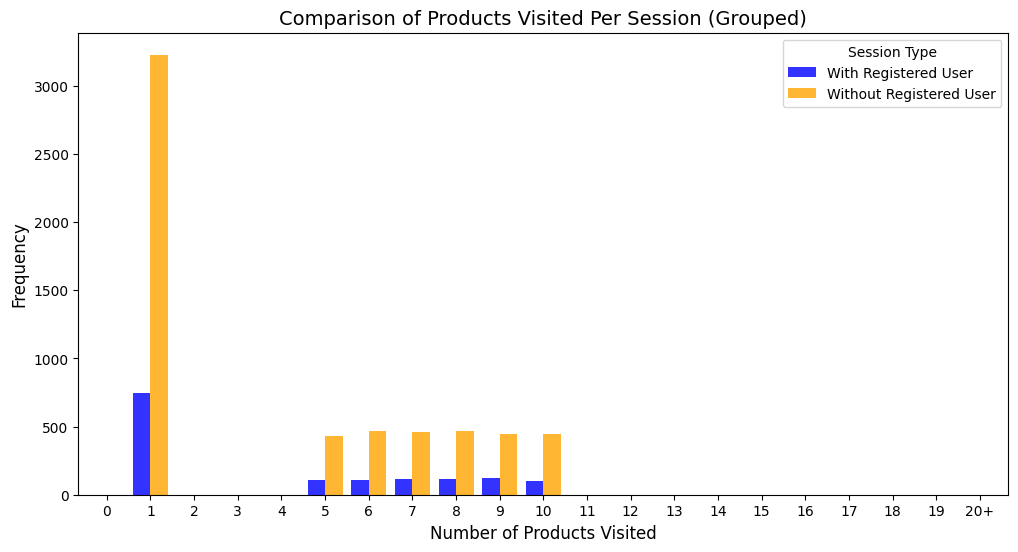

In [32]:
analyze_dataset(test_df)

There are 4573756 unique sessions in the dataset.
The average number of products visited in a session is 10.18.


C:\Users\afred\AppData\Local\Temp\ipykernel_16308\3415260545.py:15: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  avg_purchases_per_session = df.groupby('session_id').agg(purchases=('add_to_cart', sum))['purchases'].mean().round(2)


The average number of purchases per session is 0.6.
There are 380052 unique users in the dataset.
There are 4061730 sessions without a registered user.
This is 88.80513083776222% of all sessions.
There are 41995 unique products in the dataset.


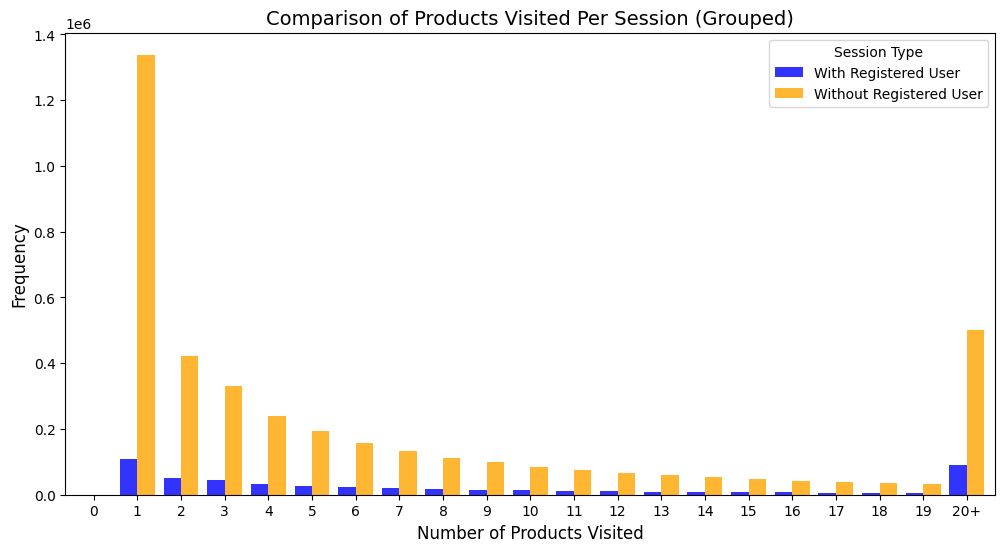

In [33]:
analyze_dataset(train_df, test = False)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_train_test(train_df, test_df):
    # Unique users and products in train and test
    train_users = set(train_df['user_id'].dropna())
    test_users = set(test_df['user_id'].dropna())
    train_products = set(train_df['partnumber'])
    test_products = set(test_df['partnumber'])

    # Users comparison
    common_users = train_users & test_users
    train_only_users = train_users - test_users
    test_only_users = test_users - train_users

    print(f"Number of unique users in train: {len(train_users)}")
    print(f"Number of unique users in test: {len(test_users)}")
    print(f"Number of users in both train and test: {len(common_users)}")
    print(f"Number of users only in train: {len(train_only_users)}")
    print(f"Number of users only in test: {len(test_only_users)}")

    # Products comparison
    common_products = train_products & test_products
    train_only_products = train_products - test_products
    test_only_products = test_products - train_products

    print(f"\nNumber of unique products in train: {len(train_products)}")
    print(f"Number of unique products in test: {len(test_products)}")
    print(f"Number of products in both train and test: {len(common_products)}")
    print(f"Number of products only in train: {len(train_only_products)}")
    print(f"Number of products only in test: {len(test_only_products)}")


In [37]:
compare_train_test(train_df,test_df)

Number of unique users in train: 380052
Number of unique users in test: 1411
Number of users in both train and test: 495
Number of users only in train: 379557
Number of users only in test: 916

Number of unique products in train: 41995
Number of unique products in test: 9253
Number of products in both train and test: 8983
Number of products only in train: 33012
Number of products only in test: 270


The average number of visits before purchase is: 1.83


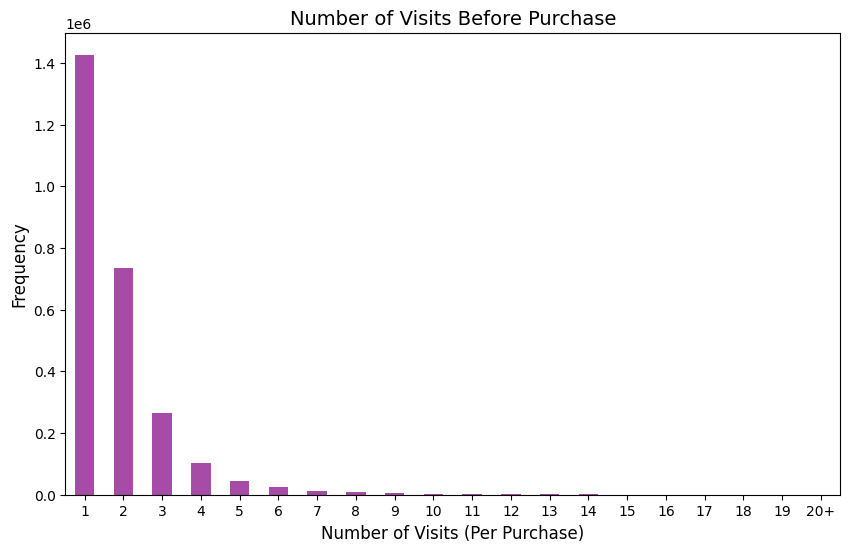

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_visits_before_purchase(train_df):
    # Step 1: Filter rows where an item was added to the cart
    added_to_cart = train_df[train_df['add_to_cart'] > 0]
    
    # Step 2: Count total visits and total purchases per (session_id, partnumber)
    visits_per_item = train_df.groupby(['session_id', 'partnumber']).size().reset_index(name='visit_count')
    purchases_per_item = added_to_cart.groupby(['session_id', 'partnumber'])['add_to_cart'].sum().reset_index(name='purchase_count')
    
    # Step 3: Merge visits and purchases
    combined = purchases_per_item.merge(visits_per_item, on=['session_id', 'partnumber'], how='inner')
    
    # Step 4: Calculate visits per purchase for each product
    combined['visits_per_purchase'] = combined['visit_count'] / combined['purchase_count']
    
    # Step 5: Calculate the overall average
    average_visits = combined['visits_per_purchase'].mean()
    print(f"The average number of visits before purchase is: {average_visits:.2f}")
    
    # Step 6: Plot the histogram
    plt.figure(figsize=(10, 6))
    bins = list(range(1, 21)) + [np.inf]  # Group everything beyond 20 visits
    labels = list(range(1, 20)) + ['20+']
    
    visit_counts_clipped = combined['visits_per_purchase'].clip(upper=20)
    visit_counts_binned = pd.cut(visit_counts_clipped, bins=bins, labels=labels, right=False)
    
    visit_counts_binned.value_counts(sort=False).plot(kind='bar', color='purple', alpha=0.7)
    plt.title("Number of Visits Before Purchase", fontsize=14)
    plt.xlabel("Number of Visits (Per Purchase)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0)
    plt.show()



plot_visits_before_purchase(train_df)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_visits_before_purchase_with_dates(train_df):
    # Step 1: Filter rows where an item was added to the cart
    added_to_cart = train_df[train_df['add_to_cart'] > 0]
    print(added_to_cart.shape)
    # Step 2: Sort the dataset by session_id, partnumber, and timestamp
    train_df = train_df.sort_values(by=['session_id', 'partnumber', 'timestamp_local'])
    
    # Step 3: Initialize a list to store visits per purchase
    visits_before_purchases = []
    i=0
    # Step 4: Loop through each purchase
    for row in added_to_cart.itertuples():
        print(i)
        i=+1
        session = row.session_id
        product = row.partnumber
        purchase_time = row.timestamp_local

        # Count visits to the same product in the same session before this purchase
        visits = train_df[
            (train_df['session_id'] == session) &
            (train_df['partnumber'] == product) &
            (train_df['timestamp_local'] < purchase_time)
        ].shape[0]
        
        visits_before_purchases.append(visits)

    # Step 5: Calculate the overall average
    average_visits = np.mean(visits_before_purchases)
    print(f"The average number of visits before purchase is: {average_visits:.2f}")
    
    # Step 6: Plot the histogram
    plt.figure(figsize=(10, 6))
    bins = list(range(1, 21)) + [np.inf]  # Group everything beyond 20 visits
    labels = list(range(1, 20)) + ['20+']
    
    visit_counts_clipped = np.clip(visits_before_purchases, a_min=None, a_max=20)
    visit_counts_binned = pd.cut(visit_counts_clipped, bins=bins, labels=labels, right=False)
    
    visit_counts_binned.value_counts(sort=False).plot(kind='bar', color='blue', alpha=0.7)
    plt.title("Number of Visits Before Purchase (Using Dates)", fontsize=14)
    plt.xlabel("Number of Visits (Per Purchase)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0)
    plt.show()


plot_visits_before_purchase_with_dates(train_df)

(2745783, 9)


KeyboardInterrupt: 

In [48]:
df1 = pd.pivot_table(train_df,index=['session_id','partnumber'], aggfunc='sum', values='add_to_cart').reset_index()
df1[df1['add_to_cart']>1].shape[0]

99569

## Most popular Items

If we just recommend the top 5 most popular items the score is 3/900

In [6]:
import pandas as pd
import json

# Step 1: Get the top 5 most popular items from train_df
top_5_items = train_df['partnumber'].value_counts().head(5).index.tolist()

# Step 2: Create the target dictionary
target = {}

for session_id in test_df['session_id'].unique():
    target[str(session_id)] = top_5_items  # Convert session_id to string

# Step 3: Format the result as a JSON object
result = {
    "target": target
}

# Convert the result to JSON format
result_json = json.dumps(result, indent=4)

# Step 4: Save the JSON to a file
output_file = "./predictions/predictions_3_popular.json"

with open(output_file, "w") as f:
    json.dump(result, f, indent=4)

print(f"JSON saved to {output_file}")

JSON saved to ./predictions/predictions_3_popular.json


I we divide by country it does not get better 3/900

In [7]:
# Step 1: Get the most popular items per country
country_popular_items = (
    train_df.groupby(['country', 'partnumber'])
    .size()
    .reset_index(name='visit_count')
    .sort_values(by=['country', 'visit_count'], ascending=[True, False])
)

# Create a dictionary of popular items for each country 
popular_items_by_country = (
    country_popular_items.groupby('country')['partnumber']
    .apply(list)
    .to_dict()
)

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    country = group['country'].iloc[0]

    top_5_items = popular_items_by_country.get(country, [])[:5]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("predictions_3_pop_country.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


Recommendations saved to 'recommendations.json'


Now we will try and recommend discounted items

In [8]:
# Merge with products_df to get the family column
df1 = train_df.merge(products_df[['partnumber', 'discount']], how='left', on='partnumber')
df1 = df1[df1['discount']==1]
# Step 1: Get the most popular items per country
country_popular_items = (
    df1.groupby(['country', 'partnumber'])
    .size()
    .reset_index(name='visit_count')
    .sort_values(by=['country', 'visit_count'], ascending=[True, False])
)

# Create a dictionary of popular items for each country 
popular_items_by_country = (
    country_popular_items.groupby('country')['partnumber']
    .apply(list)
    .to_dict()
)

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    country = group['country'].iloc[0]

    top_5_items = popular_items_by_country.get(country, [])[:5]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("predictions_3_pop_country.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


Recommendations saved to 'recommendations.json'


## Recommend visited items

In [40]:
import pandas as pd
import json

# Step 1: Identify the top 5 most popular items
top_5_popular_items = train_df['partnumber'].value_counts().head(5).index.tolist()

# Step 2: Create a function to process items for each session
def process_session_items(session_items, top_items, max_items=5):
    if len(session_items) < max_items:
        # Fill with top popular items if the list is smaller than max_items
        session_items += [item for item in top_items if item not in session_items][:max_items - len(session_items)]
    else:
        # Truncate the list to max_items
        session_items = session_items[:max_items]
    return session_items

# Step 3: Create the target dictionary
target = {}

for session_id, group in test_df.groupby('session_id'):
    # Extract visited items in the session
    visited_items = group['partnumber'].tolist()
    
    # Process the session items
    target[str(session_id)] = process_session_items(visited_items, top_5_popular_items)

# Step 4: Format the result as a JSON object
result = {
    "target": target
}

# Step 5: Save the JSON to a file
output_file = "./predictions/predictions_3.json"

with open(output_file, "w") as f:
    json.dump(result, f, indent=4)

print(f"JSON saved to {output_file}")


JSON saved to ./predictions/predictions_3.json


## Visited items and other sessions history

In [11]:
import pandas as pd
import json
import numpy as np

#Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df,test_user_hist], axis = 0)

# Step 1: Get the most popular items overall
popular_items = train_df['partnumber'].value_counts().index.tolist()

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].min()
    if np.isnan(user_id):
        # Count visits for each item within the session
        item_counts = group['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        if len(top_5_items) < 5:
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

        # Add to recommendations
        recommendations[session_id] = top_5_items
    else:
        history = extended_test[(extended_test['user_id'] == user_id)]
        #history = extended_test[(extended_test['user_id'] == user_id)&(extended_test('timestamp_local')<date)]
        # Count visits for each item within the sessions
        item_counts = history['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        if len(top_5_items) < 5:
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


Recommendations saved to 'recommendations.json'


## History and recency weight

In [9]:
#Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df,test_user_hist], axis = 0)

C:\Users\afred\AppData\Local\Temp\ipykernel_19288\4094760686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
C:\Users\afred\AppData\Local\Temp\ipykernel_19288\4094760686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
C:\Users\afred\AppData\Local\Temp\ipykernel_19288\4094760686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy

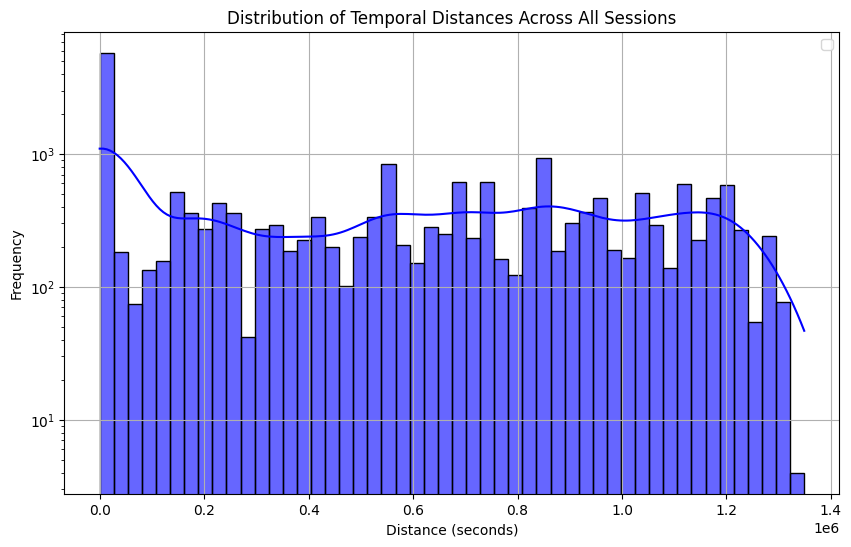

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect distances for all sessions
all_distances = []

for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()

    if not pd.isna(user_id):
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
        
        # Calculate the temporal distance
        history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
        all_distances.extend(history['distance'].tolist())

# Convert to a DataFrame for plotting
distances_df = pd.DataFrame({'distance': all_distances})

# Plot the distribution of distances
plt.figure(figsize=(10, 6))
sns.histplot(distances_df['distance'], bins=50, kde=True, color='blue', alpha=0.6)
plt.title('Distribution of Temporal Distances Across All Sessions')
plt.xlabel('Distance (seconds)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use logarithmic scale for better visibility (optional)
plt.grid(True)

"""# Optionally, overlay decay functions for different constants
x = np.linspace(0, distances_df['distance'].max(), 500)
for k in [0.00001, 0.00005, 0.0001]:  # Different decay rates
    decay = np.exp(-k * x)
    plt.plot(x, decay * len(all_distances) * 10, label=f'Decay (k={k})')  # Adjust scaling for overlay"""

plt.legend()
plt.show()


In [15]:
import pandas as pd
import json
import numpy as np

# Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df, test_user_hist], axis=0)

# Step 1: Get the most popular items overall
popular_items = train_df['partnumber'].value_counts().index.tolist()

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()

    if pd.isna(user_id):
        # Count visits for each item within the session
        item_counts = group['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    else:
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
        #remove already purchased items
        purchased = pd.pivot_table(history, index = 'partnumber',aggfunc='sum',values='add_to_cart')
        not_purchased = purchased[~purchased['add_to_cart']>0]
        # Count visits for each item in the user's history
        item_counts = history.loc[history['partnumber'].isin(not_purchased),'partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


Recommendations saved to 'recommendations.json'


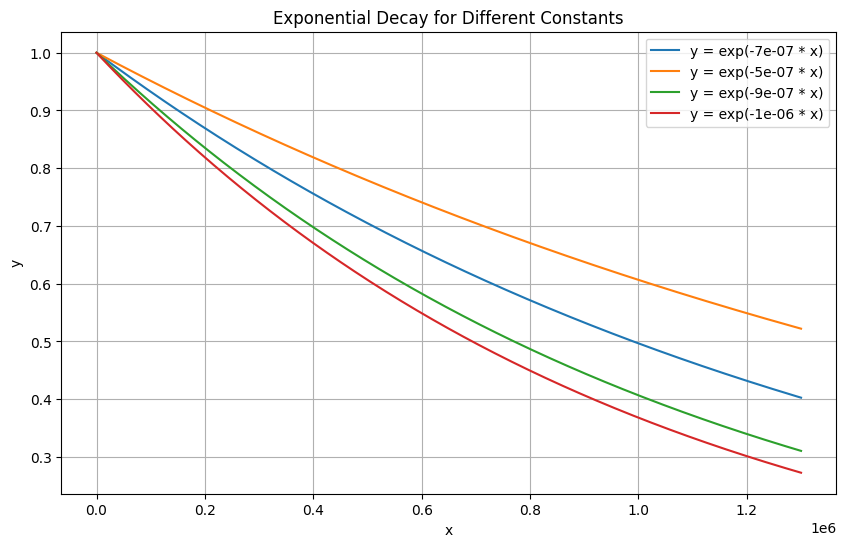

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Define multiple constants for comparison
constants = [-0.0000007,-0.0000005,-0.0000009, -0.000001]
x_values = np.linspace(0, 1.3e6, 500)

# Plot exponential decay for different constants
plt.figure(figsize=(10, 6))
for constant in constants:
    y_values = np.exp(constant * x_values)
    plt.plot(x_values, y_values, label=f"y = exp({constant} * x)")

plt.title("Exponential Decay for Different Constants")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# Merge with products_df to get the family column
df1 = train_df.merge(products_df[['partnumber', 'discount']], how='left', on='partnumber')
df1 = df1[df1['discount']==1]

In [12]:
import pandas as pd
import json
import numpy as np
#exponential decay constant
k = -0.00001

# Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df, test_user_hist], axis=0)

# Step 1: Get the most popular items per country
country_popular_items = (
    df1.groupby(['country', 'partnumber'])
    .size()
    .reset_index(name='visit_count')
    .sort_values(by=['country', 'visit_count'], ascending=[True, False])
)

# Create a dictionary of popular items for each country
popular_items_by_country = (
    country_popular_items.groupby('country')['partnumber']
    .apply(list)
    .to_dict()
)


# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()
    country = group['country'].iloc[0]
    popular_items = popular_items_by_country.get(country, [])
    if pd.isna(user_id):
        # Count visits for each item within the session
        item_counts = group['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    else:
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]

        # Calculate the temporal distance and weight
        history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
        history['weight'] = np.exp(k * history['distance'])  # Adjust the decay rate as needed

        # Multiply visit counts by weight
        weighted_visits = history.groupby('partnumber')['weight'].sum().reset_index()
        weighted_visits.columns = ['partnumber', 'weighted_score']

        # Sort items by weighted score in descending order
        sorted_items = weighted_visits.sort_values(by='weighted_score', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("predictions_3.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'predictions_3.json'")


C:\Users\afred\AppData\Local\Temp\ipykernel_13008\1676118020.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
C:\Users\afred\AppData\Local\Temp\ipykernel_13008\1676118020.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['weight'] = np.exp(k * history['distance'])  # Adjust the decay rate as needed
C:\Users\afred\AppData\Local\Temp\ipykernel_13008\1676118020.py:57: SettingWithCopyWarning: 
A value is trying to be set

Recommendations saved to 'predictions_3.json'


In [ ]:
import pandas as pd
import numpy as np
import json

# Parameters
decay_constant = 0.00001  # Adjust this value for the exponential decay function

# Step 1: Get the most popular items per country
country_popular_items = (
    train_df.groupby(['country', 'partnumber'])
    .size()
    .reset_index(name='visit_count')
    .sort_values(by=['country', 'visit_count'], ascending=[True, False])
)

# Create a dictionary of popular items for each country
popular_items_by_country = (
    country_popular_items.groupby('country')['partnumber']
    .apply(list)
    .to_dict()
)

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    country = group['country'].iloc[0]
    date = group['timestamp_local'].max()

    if pd.isna(user_id):
        # If user_id is NaN, recommend popular items for the session's country
        top_5_items = popular_items_by_country.get(country, [])[:5]
    else:
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ].copy()

        # Calculate temporal distance and recency weights
        history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
        history['weight'] = np.exp(-decay_constant * history['distance'])

        # Aggregate weighted scores for each product
        item_scores = (
            history.groupby('partnumber')
            .agg(weighted_score=('weight', 'sum'))
            .reset_index()
            .sort_values(by='weighted_score', ascending=False)
        )

        # Get the top 5 items based on weighted scores
        top_5_items = item_scores['partnumber'].tolist()[:5]

        # Fill remaining slots with popular items from the user's country
        if len(top_5_items) < 5:
            top_5_items += [
                item
                for item in popular_items_by_country.get(country, [])
                if item not in top_5_items
            ][: 5 - len(top_5_items)]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


## SVD Factorization

In [6]:
import pandas as pd
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import numpy as np

In [7]:
train_users = set(train_df['user_id'])
test_users = set(test_df['user_id'])

# Users comparison
common_users = train_users & test_users

In [9]:
# Step 1: Filter out users with insufficient data
user_purchases = train_df.groupby('user_id')['partnumber'].count().reset_index()
user_purchases = user_purchases[user_purchases['partnumber'] > 3]  # Keep users with >3 interactions
filtered_users = user_purchases['user_id'].tolist()

# Step 2: Sample users
sampled_users = pd.Series(filtered_users).sample(100000, random_state=42).tolist()  # Sample 10,000 users
sampled_users_set = set(sampled_users)
users_to_add = common_users - sampled_users_set
sampled_users.extend(list(users_to_add))
# Step 3: Filter dataset for sampled users
sampled_df = train_df[train_df['user_id'].isin(sampled_users)]

# Step 4: Create User-Item Matrix (Retain All Items)
user_item_matrix = sampled_df.pivot_table(
    values='add_to_cart', index='user_id', columns='partnumber', fill_value=0
)

# Step 5: Convert to Sparse Matrix
user_item_sparse = csr_matrix(user_item_matrix.values)


C:\Users\afred\AppData\Local\Temp\ipykernel_11532\184047338.py:15: PerformanceWarning: The following operation may generate 2299127552 cells in the resulting pandas object.
  user_item_matrix = sampled_df.pivot_table(


In [10]:
from scipy.sparse import save_npz

# Save sparse matrix
save_npz("user_item_sparse.npz", user_item_sparse)
# Save the user index and item columns
np.save("user_index.npy", user_item_matrix.index.values)  # User IDs
np.save("item_columns.npy", user_item_matrix.columns.values)  # Part numbers

In [14]:
from scipy.sparse import load_npz

# Load the sparse matrix
user_item_sparse = load_npz("user_item_sparse.npz")
assert isinstance(user_item_sparse, csr_matrix)

# Load the user index and item columns
user_index = np.load("user_index.npy", allow_pickle=True)  # User IDs
item_columns = np.load("item_columns.npy", allow_pickle=True)  # Part numbers

# Reconstruct the user-item matrix as a DataFrame (optional)
user_item_matrix = pd.DataFrame.sparse.from_spmatrix(
    user_item_sparse, index=user_index, columns=item_columns
)

In [11]:

# Step 6: Perform SVD
U, sigma, Vt = svds(user_item_sparse, k=50)

# Step 7: Reconstruct the matrix for predictions
sigma = np.diag(sigma)
predicted_scores = np.dot(np.dot(U, sigma), Vt)

# Step 8: Convert Predicted Scores to DataFrame
predicted_df = pd.DataFrame(predicted_scores, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Example: Get top 5 recommendations for a user
def recommend(user_id, top_n=5):
    if user_id in predicted_df.index:
        user_scores = predicted_df.loc[user_id]
        top_items = user_scores.sort_values(ascending=False).head(top_n).index.tolist()
        return top_items
    else:
        # Handle unseen users
        return ["Popular item recommendations"]  # Fallback for new users

# Example Usage
#user_id = sampled_users[0]
#print(f"Top recommendations for user {user_id}: {recommend(user_id)}")


In [12]:
test_users = test_df['user_id'].unique()
test_user_predictions = predicted_df.loc[predicted_df.index.isin(test_users)]
test_user_predictions.to_csv('test_user_predictions.csv')

In [21]:
predicted_df

3             4             5             8      \
1.0      -1.148728e-32  1.970860e-18  8.115738e-19  3.090245e-20   
2.0      -1.104609e-19  2.373906e-05  7.503593e-06  5.325270e-06   
6.0       1.254220e-18  2.932728e-04  8.674706e-05  2.082855e-05   
11.0      1.190941e-18  4.140886e-05  2.394544e-05  7.014721e-06   
24.0      3.797695e-18  2.035760e-04  2.847855e-04  6.595726e-05   
...                ...           ...           ...           ...   
556966.0  2.013846e-17 -7.881216e-05 -2.291911e-04  6.985458e-05   
556967.0  1.735804e-19  8.388601e-06  1.542744e-06  4.968283e-07   
556981.0 -9.014078e-21  1.407196e-05  7.501247e-06 -3.672511e-08   
556985.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
557003.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 11            12            14            18     \
1.0       2.452064e-17 -8.370574e-33  1.695232e-19  2.710473e-19   
2.0      -2.497829e-04  4.607122e-19  8.367085e-06 -4.347495e-05   
6.0      -2.090900e-04  2.827167e-18  1.172669e-06 -8.063197e-05   
11.0      4.393220e-04  1.948077e-19  3.917165e-06 -1.068378e-05   
24.0     -9.580971e-04  6.742753e-19  5.670400e-05 -3.689016e-05   
...                ...           ...           ...           ...   
556966.0  8.579896e-04 -7.379122e-18 -5.997061e-05  1.733812e-04   
556967.0  9.258281e-05  2.977738e-19 -1.522620e-06  2.624871e-06   
556981.0  3.483967e-04 -2.740533e-20  5.669981e-10  4.504314e-06   
556985.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
557003.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 20            22     ...         43629         43630  \
1.0       2.481520e-18 -2.976227e-20  ...  6.001296e-20  2.853736e-18   
2.0       1.871938e-05  3.182532e-05  ... -7.724556e-09  3.831039e-04   
6.0       2.303888e-04  1.756644e-04  ...  2.383601e-07 -1.545298e-04   
11.0      3.328363e-05  1.608257e-05  ... -2.023140e-07  1.165534e-04   
24.0      1.957009e-04  3.259963e-04  ... -2.331147e-06 -8.370716e-04   
...                ...           ...  ...           ...           ...   
556966.0 -1.276249e-04  1.642813e-04  ... -2.547324e-06 -2.093093e-03   
556967.0  4.676469e-06  3.101286e-08  ... -9.101386e-08 -7.481479e-05   
556981.0  2.174438e-05 -6.502724e-07  ...  5.466023e-07 -3.187722e-06   
556985.0  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
557003.0  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   

                 43632  43633  43635         43636         43637  43639  \
1.0      -7.012616e-19    0.0    0.0  1.053560e-20  1.294599e-17    0.0   
2.0       9.787357e-05    0.0    0.0 -5.483565e-08  1.006223e-03    0.0   
6.0      -3.729521e-05    0.0    0.0 -8.532789e-08 -1.147911e-04    0.0   
11.0      1.262609e-04    0.0    0.0 -6.766542e-07 -4.525382e-04    0.0   
24.0      1.363437e-03    0.0    0.0 -1.882048e-06 -1.819893e-03    0.0   
...                ...    ...    ...           ...           ...    ...   
556966.0 -4.488121e-04    0.0    0.0 -6.759193e-06 -7.019779e-04    0.0   
556967.0 -2.784405e-05    0.0    0.0  7.107004e-07 -9.324382e-05    0.0   
556981.0 -1.077524e-06    0.0    0.0 -3.397237e-09 -6.857175e-06    0.0   
556985.0  0.000000e+00    0.0    0.0  0.000000e+00  0.000000e+00    0.0   
557003.0  0.000000e+00    0.0    0.0  0.000000e+00  0.000000e+00    0.0   

                 43645  43647  
1.0      -1.461818e-20    0.0  
2.0       4.194072e-07    0.0  
6.0       2.409732e-06    0.0  
11.0      1.255388e-06    0.0  
24.0      6.291147e-06    0.0  
...                ...    ...  
556966.0 -3.392978e-07    0.0  
556967.0  3.485821e-07    0.0  
556981.0  9.216864e-09    0.0  
556985.0  0.000000e+00    0.0  
557003.0  0.000000e+00    0.0  

[100000 rows x 22904 columns]

### Clustering (did not work)

   partnumber  cluster
0           3        1
1           4        1
2           5        1
3           8        1
4          11        0


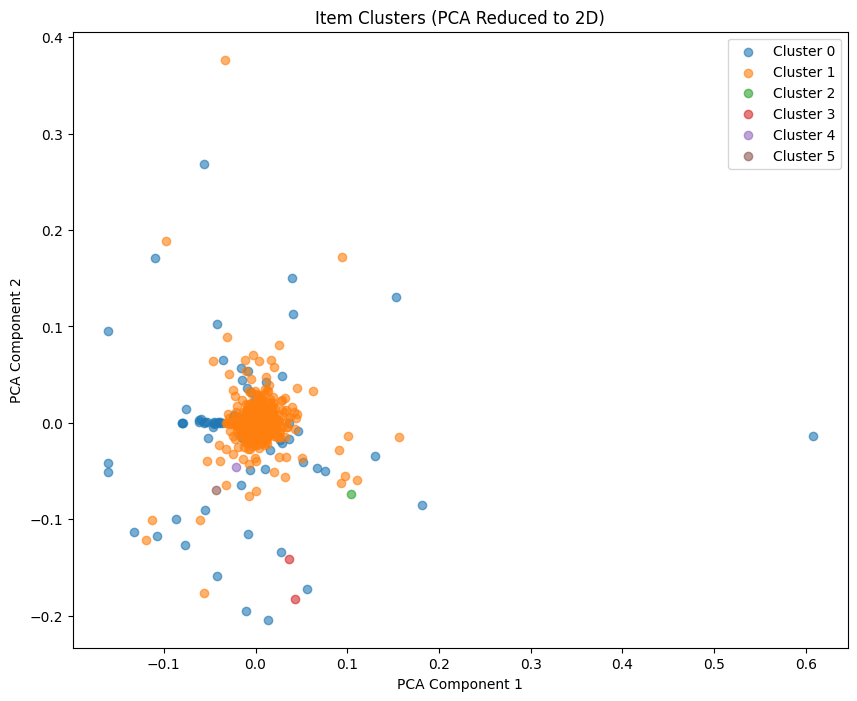

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Extract item vectors (latent features from Vt)
item_vectors = Vt.T  # Transpose so rows correspond to items

# Step 2: Perform clustering
num_clusters = 6  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
item_clusters = kmeans.fit_predict(item_vectors)

# Step 3: Assign cluster labels to items
item_cluster_mapping = pd.DataFrame({
    'partnumber': user_item_matrix.columns,
    'cluster': item_clusters
})

print(item_cluster_mapping.head())  # Preview the mapping of items to clusters

# Step 4: Optional - Visualize clusters (2D projection using PCA)
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(item_vectors)

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_vectors[item_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title("Item Clusters (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [10]:
products_df

discount                                          embedding  partnumber  \
0            0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1            0  [-0.0949274, -0.107294075, -0.16559914, -0.174...       41431   
2            0  [-0.12904441, -0.07724628, -0.09799071, -0.164...       39419   
3            1  [-0.12783332, -0.133868, -0.10101265, -0.18888...       36087   
4            1  [-0.14092924, -0.1258284, -0.10809927, -0.1765...       34132   
...        ...                                                ...         ...   
43687        0  [-0.1725829, 0.780391, -0.16265817, -0.1397962...         234   
43688        0  [-0.08114546, 0.7171631, 0.2157723, -0.1599884...         235   
43689        0  [-0.1517721, 1.640085, -0.1506274, -0.06088442...         236   
43690        0  [-0.078192495, 0.012600096, -0.085486665, 0.49...         237   
43691        0  [-0.12523538, 0.058919854, -0.14703132, -0.185...         238   

       color_id  cod_section  family  
0            85          4.0      73  
1           135          4.0      73  
2           339          4.0      73  
3           135          4.0      73  
4             3          4.0      73  
...         ...          ...     ...  
43687       368          2.0     192  
43688       152          2.0     138  
43689       226          2.0     135  
43690       122          2.0      10  
43691        85          2.0     207  

[43692 rows x 6 columns]

In [12]:
products_df['cluster'].value_counts()

cluster
 1.0    22827
-1.0    20788
 0.0       72
 3.0        2
 5.0        1
 2.0        1
 4.0        1
Name: count, dtype: int64

In [11]:
products_df = products_df.merge(item_cluster_mapping, how='left', on='partnumber')
products_df['cluster'] = products_df['cluster'].fillna(-1)

In [11]:
products_df.to_csv('products_processed.csv')

In [18]:
%whos

Variable                   Type          Data/Info
--------------------------------------------------
KMeans                     ABCMeta       <class 'sklearn.cluster._kmeans.KMeans'>
PCA                        ABCMeta       <class 'sklearn.decomposition._pca.PCA'>
U                          ndarray       100000x50: 5000000 elems, type `float64`, 40000000 bytes (38.14697265625 Mb)
Vt                         ndarray       50x22904: 1145200 elems, type `float64`, 9161600 bytes (8.7371826171875 Mb)
cluster                    float         1.0
cluster_items              list          n=22832
cluster_points             ndarray       1x2: 2 elems, type `float64`, 16 bytes
cluster_popularity         DataFrame            cluster  partnumbe<...>n[41995 rows x 3 columns]
csr_matrix                 type          <class 'scipy.sparse._csr.csr_matrix'>
date                       Timestamp     2024-06-15 19:09:48.136000
extended_test              DataFrame               session_id     <...>[43898 ro

In [19]:
import sys

# Get all local variables (you can replace locals() with globals() if needed)
variables = locals()

# Create a list of variables with their memory size
variable_sizes = [(var, sys.getsizeof(value)) for var, value in variables.items()]

# Sort the list by memory size in descending order
sorted_variables = sorted(variable_sizes, key=lambda x: x[1], reverse=True)

# Print sorted variables by memory size
for var, size in sorted_variables:
    print(f"{var}: {size / 1e6:.2f} MB")  # Convert bytes to MB for easier reading


user_item_matrix: 18326.11 MB
predicted_df: 18326.11 MB
train_df: 6470.65 MB
__: 6098.24 MB
_2: 6098.24 MB
sampled_df: 351.34 MB
products_df: 10.77 MB
Vt: 9.16 MB
extended_test: 6.45 MB
user_purchases: 6.27 MB
_: 3.84 MB
test_df: 3.84 MB
_15: 3.84 MB
test_user_hist: 2.15 MB
filtered_users: 2.09 MB
cluster_popularity: 1.34 MB
sampled_users: 0.80 MB
reduced_vectors: 0.37 MB
item_cluster_mapping: 0.27 MB
cluster_items: 0.19 MB
item_clusters: 0.09 MB
sigma: 0.02 MB
test_users: 0.01 MB
variables: 0.00 MB
_ii: 0.00 MB
_i17: 0.00 MB
_iii: 0.00 MB
_i14: 0.00 MB
_i16: 0.00 MB
KMeans: 0.00 MB
PCA: 0.00 MB
___: 0.00 MB
_1: 0.00 MB
_i9: 0.00 MB
csr_matrix: 0.00 MB
_i8: 0.00 MB
_i6: 0.00 MB
_i4: 0.00 MB
history: 0.00 MB
group: 0.00 MB
popular_items_by_cluster: 0.00 MB
_i19: 0.00 MB
_i15: 0.00 MB
_i5: 0.00 MB
_i7: 0.00 MB
_ih: 0.00 MB
In: 0.00 MB
_i1: 0.00 MB
_oh: 0.00 MB
Out: 0.00 MB
recommendations: 0.00 MB
seen_clusters: 0.00 MB
weighted_visits: 0.00 MB
_i2: 0.00 MB
_i10: 0.00 MB
_i3: 0.00 MB
ite

In [20]:
del sampled_df
del predicted_df
del user_item_matrix

In [23]:
train_df.drop(['cluster_x','cluster_y'], axis = 1, inplace = True)

In [25]:
# Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df, test_user_hist], axis=0)

In [24]:
import pandas as pd
import numpy as np
import json

# Parameters
k = 0.00001  # Adjust this value for the exponential decay function




# Step 1: Merge clusters into train_df
train_df = train_df.merge(products_df[['partnumber', 'cluster']], on='partnumber', how='left')

# Step 2: Compute popular items for each cluster
cluster_popularity = (
    train_df.groupby(['cluster', 'partnumber'])['add_to_cart']
    .sum()
    .reset_index()
    .sort_values(['cluster', 'add_to_cart'], ascending=[True, False])
)
popular_items_by_cluster = (
    cluster_popularity.groupby('cluster')['partnumber']
    .apply(list)
    .to_dict()
)


# Step 3: Process each session in the test data
recommendations = {}

for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()

    if pd.isna(user_id):
        # Count visits for each item within the session
        item_counts = group['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # If fewer than 5 items were seen, use popular items from the same clusters
        if len(sorted_items) < 5:
            # Find the clusters of items seen in the session
            seen_clusters = set(
                products_df.loc[products_df['partnumber'].isin(sorted_items), 'cluster']
            )
            seen_clusters.discard(None)  # Remove None in case some items don't have clusters

            # Get popular items from these clusters
            cluster_items = []
            for cluster in seen_clusters:
                cluster_items += popular_items_by_cluster.get(cluster, [])
            
            # Remove already seen items and take the top 5
            cluster_items = [item for item in cluster_items if item not in sorted_items]
            sorted_items += cluster_items[:5 - len(sorted_items)]

        # Add the top 5 items
        top_5_items = sorted_items[:5]

    else:
                # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]

        # Calculate the temporal distance and weight
        history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
        history['weight'] = np.exp(k * history['distance'])  # Adjust the decay rate as needed

        # Multiply visit counts by weight
        weighted_visits = history.groupby('partnumber')['weight'].sum().reset_index()
        weighted_visits.columns = ['partnumber', 'weighted_score']

        # Sort items by weighted score in descending order
        sorted_items = weighted_visits.sort_values(by='weighted_score', ascending=False)['partnumber'].tolist()

        if len(sorted_items) < 5:
            # Find the clusters of items seen in the session
            seen_clusters = set(
                products_df.loc[products_df['partnumber'].isin(sorted_items), 'cluster']
            )
            seen_clusters.discard(None)  # Remove None in case some items don't have clusters

            # Get popular items from these clusters
            cluster_items = []
            for cluster in seen_clusters:
                cluster_items += popular_items_by_cluster.get(cluster, [])
            
            # Remove already seen items and take the top 5
            cluster_items = [item for item in cluster_items if item not in sorted_items]
            sorted_items += cluster_items[:5 - len(sorted_items)]

        # Add the top 5 items
        top_5_items = sorted_items[:5]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['weight'] = np.exp(k * history['distance'])  # Adjust the decay rate as needed
C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:74: SettingWithCopyWarning: 
A value is trying to be set

Recommendations saved to 'recommendations.json'


C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['distance'] = (date - history['timestamp_local']).dt.total_seconds()
C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['weight'] = np.exp(k * history['distance'])  # Adjust the decay rate as needed
C:\Users\afred\AppData\Local\Temp\ipykernel_10100\4100565109.py:74: SettingWithCopyWarning: 
A value is trying to be set

### Using scores

In [18]:
import pandas as pd
import json
import numpy as np

# Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df, test_user_hist], axis=0)

# Step 1: Get the most popular items overall
popular_items = train_df['partnumber'].value_counts().index.tolist()

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()

    if pd.isna(user_id):
        # Count visits for each item within the session
        item_counts = group['partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        # Add the top 5 items, filling with popular items if needed
        top_5_items = sorted_items[:5]
        top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    else:
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
        # Remove already purchased items
        purchased = pd.pivot_table(history, index='partnumber', aggfunc='sum', values='add_to_cart')
        not_purchased = purchased[~purchased['add_to_cart'] > 0]

        # Count visits for each item in the user's history
        item_counts = history.loc[history['partnumber'].isin(not_purchased), 'partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        if user_id in test_user_predictions.index:
            # Get the top predicted items for that user and add them to the top_5_items
            predicted_items = test_user_predictions.loc[user_id].nlargest(5).index.tolist()  # Get top 5 predictions
            top_5_items = predicted_items[:5]  # Priority to predictions

            # Add additional items from the user's history, if needed
            remaining_slots = 5 - len(top_5_items)
            top_5_items += [item for item in sorted_items if item not in top_5_items][:remaining_slots]

            # Fill in with popular items if there are still missing slots
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

        else:
            # If no predictions, just use the history and popular items
            top_5_items = sorted_items[:5]
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


Recommendations saved to 'recommendations.json'


In [23]:
import pandas as pd
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Historical data
test_users = test_df['user_id'].unique().tolist()
test_user_hist = train_df.dropna(subset=['user_id'])
test_user_hist = test_user_hist[test_user_hist['user_id'].isin(test_users)]
extended_test = pd.concat([test_df, test_user_hist], axis=0)

# Step 1: Get the most popular items overall
popular_items = train_df['partnumber'].value_counts().index.tolist()

# Step 2: Create a dictionary for recommendations
recommendations = {}

# Step 3: Process each session in the test data
for session_id, group in test_df.groupby('session_id'):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()

    if pd.isna(user_id):
        # If user has visited only one item in this session
        if len(group) == 1:
            visited_item = group['partnumber'].iloc[0]
            
            # Retrieve the embedding of the visited item
            visited_item_embedding = np.array(products_df[products_df['partnumber'] == visited_item]['embedding'].values[0])

            # Compute cosine similarities with all items
            all_embeddings = products_df['embedding'].values  # Convert each embedding to numpy arrays
            similarities = cosine_similarity(visited_item_embedding.reshape(-1, 1), all_embeddings).flatten()  # Get cosine similarity
            most_similar_indices = similarities.argsort()[-5:][::-1]  # Get indices of top 5 most similar items

            # Get the partnumbers of the most similar items
            top_5_similar_items = products_df.iloc[most_similar_indices]['partnumber'].tolist()

            # Remove the visited item from the recommended list (if it's included)
            top_5_similar_items = [item for item in top_5_similar_items if item != visited_item]
            
            # If there are not enough items, fill with popular items
            top_5_items = top_5_similar_items[:4] + [item for item in popular_items if item not in top_5_similar_items][:5 - len(top_5_similar_items)]

        else:
            # Count visits for each item within the session
            item_counts = group['partnumber'].value_counts().reset_index()
            item_counts.columns = ['partnumber', 'visit_count']

            # Sort items by visit count in descending order
            sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

            # Add the top 5 items, filling with popular items if needed
            top_5_items = sorted_items[:5]
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    else:
        # Filter history for the user and include only interactions before the session's timestamp
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
        # Remove already purchased items
        purchased = pd.pivot_table(history, index='partnumber', aggfunc='sum', values='add_to_cart')
        not_purchased = purchased[~purchased['add_to_cart'] > 0]

        # Count visits for each item in the user's history
        item_counts = history.loc[history['partnumber'].isin(not_purchased), 'partnumber'].value_counts().reset_index()
        item_counts.columns = ['partnumber', 'visit_count']

        # Sort items by visit count in descending order
        sorted_items = item_counts.sort_values(by='visit_count', ascending=False)['partnumber'].tolist()

        if user_id in test_user_predictions.index:
            # Get the top predicted items for that user and add them to the top_5_items
            predicted_items = test_user_predictions.loc[user_id].nlargest(5).index.tolist()  # Get top 5 predictions
            top_5_items = predicted_items[:5]  # Priority to predictions

            # Add additional items from the user's history, if needed
            remaining_slots = 5 - len(top_5_items)
            top_5_items += [item for item in sorted_items if item not in top_5_items][:remaining_slots]

            # Fill in with popular items if there are still missing slots
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

        else:
            # If no predictions, just use the history and popular items
            top_5_items = sorted_items[:5]
            top_5_items += [item for item in popular_items if item not in top_5_items][:5 - len(top_5_items)]

    # Add to recommendations
    recommendations[session_id] = top_5_items

# Step 4: Save recommendations as a JSON file
output = {"target": recommendations}

with open("recommendations.json", "w") as f:
    json.dump(output, f)

print("Recommendations saved to 'recommendations.json'")


ValueError: setting an array element with a sequence.

In [5]:
products_df

discount                                          embedding  partnumber  \
0            0  [-0.13401361, -0.1200429, -0.016117405, -0.167...       32776   
1            0  [-0.0949274, -0.107294075, -0.16559914, -0.174...       41431   
2            0  [-0.12904441, -0.07724628, -0.09799071, -0.164...       39419   
3            1  [-0.12783332, -0.133868, -0.10101265, -0.18888...       36087   
4            1  [-0.14092924, -0.1258284, -0.10809927, -0.1765...       34132   
...        ...                                                ...         ...   
43687        0  [-0.1725829, 0.780391, -0.16265817, -0.1397962...         234   
43688        0  [-0.08114546, 0.7171631, 0.2157723, -0.1599884...         235   
43689        0  [-0.1517721, 1.640085, -0.1506274, -0.06088442...         236   
43690        0  [-0.078192495, 0.012600096, -0.085486665, 0.49...         237   
43691        0  [-0.12523538, 0.058919854, -0.14703132, -0.185...         238   

       color_id  cod_section  family  
0            85          4.0      73  
1           135          4.0      73  
2           339          4.0      73  
3           135          4.0      73  
4             3          4.0      73  
...         ...          ...     ...  
43687       368          2.0     192  
43688       152          2.0     138  
43689       226          2.0     135  
43690       122          2.0      10  
43691        85          2.0     207  

[43692 rows x 6 columns]

In [6]:
products_df[['partnumber','embedding']]

partnumber                                          embedding
0           32776  [-0.13401361, -0.1200429, -0.016117405, -0.167...
1           41431  [-0.0949274, -0.107294075, -0.16559914, -0.174...
2           39419  [-0.12904441, -0.07724628, -0.09799071, -0.164...
3           36087  [-0.12783332, -0.133868, -0.10101265, -0.18888...
4           34132  [-0.14092924, -0.1258284, -0.10809927, -0.1765...
...           ...                                                ...
43687         234  [-0.1725829, 0.780391, -0.16265817, -0.1397962...
43688         235  [-0.08114546, 0.7171631, 0.2157723, -0.1599884...
43689         236  [-0.1517721, 1.640085, -0.1506274, -0.06088442...
43690         237  [-0.078192495, 0.012600096, -0.085486665, 0.49...
43691         238  [-0.12523538, 0.058919854, -0.14703132, -0.185...

[43692 rows x 2 columns]

In [17]:
products_df['embedding'].values

array([array([-0.13401361, -0.1200429 , -0.01611741, ...,  0.02165968,
              -0.21677604, -0.08010305], shape=(1280,), dtype=float32),
       array([-0.0949274 , -0.10729408, -0.16559914, ...,  0.00372908,
               0.03755572, -0.04457531], shape=(1280,), dtype=float32),
       array([-0.12904441, -0.07724628, -0.09799071, ...,  0.14657502,
              -0.11429937,  0.00204693], shape=(1280,), dtype=float32),
       ...,
       array([-0.1517721 ,  1.640085  , -0.1506274 , ..., -0.02000022,
              -0.09097413, -0.10008639], shape=(1280,), dtype=float32),
       array([-0.07819249,  0.0126001 , -0.08548667, ...,  0.17747042,
              -0.13477576, -0.09586591], shape=(1280,), dtype=float32),
       array([-0.12523538,  0.05891985, -0.14703132, ...,  1.7869892 ,
              -0.21361285, -0.07270793], shape=(1280,), dtype=float32)],
      shape=(43692,), dtype=object)

In [26]:
import pandas as pd
import numpy as np

# Assuming extended_test is your dataset and predicted_df is your user-item matrix
# Assuming you have a test_df with 'session_id', 'user_id', 'timestamp_local'

def create_visit_vector_for_session(session_id, extended_test, predicted_df):
    df1 = test_df[test_df['session_id']==session_id]
    user_id = df1['user_id'].iloc[0]
    date = df1['timestamp_local'].max()  # Latest timestamp in this session
    
    # Step 1: Filter the user's history for the given session and include only interactions up to the session's date
    if not pd.isna(user_id):
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
    else:
        history = df1
        
    # Step 2: Count visits for each partnumber (item) in this session
    item_counts = history['partnumber'].value_counts().reset_index()
    item_counts.columns = ['partnumber', 'visit_count']
    
    # Step 3: Create a visit vector aligned with predicted_df's columns (the items in the matrix)
    visit_vector = []
    for item in predicted_df.columns:  # Each item in the prediction matrix
        # Get the visit count for this item, default to 0 if not in item_counts
        visit_count = item_counts[item_counts['partnumber'] == item]['visit_count']
        visit_vector.append(visit_count.iloc[0] if not visit_count.empty else 0)
        
    return np.array(visit_vector)


# Create visit vectors for each session in the test set
visit_vectors = {}

for session_id in test_df.groupby('session_id'):
    visit_vector = create_visit_vector_for_session(session_id, extended_test, predicted_df)
    if visit_vector is not None:
        user_id = group['user_id'].iloc[0]
        visit_vectors[user_id] = visit_vector

# Now visit_vectors contains visit vectors for each user (one per session) in the test set
visit_vectors_df = pd.DataFrame.from_dict(visit_vectors, orient='index', columns=predicted_df.columns)

# Output visit vectors
print(visit_vectors_df)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [28]:
import pandas as pd
import numpy as np

# Assuming extended_test is your dataset and predicted_df is your user-item matrix
# Assuming you have a test_df with 'session_id', 'user_id', 'timestamp_local'

def create_visit_vector_for_session(session_id, group, extended_test, predicted_df):
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()  # Latest timestamp in this session
    
    # Step 1: Filter the user's history for the given session and include only interactions up to the session's date
    if not pd.isna(user_id):
        history = extended_test[
            (extended_test['user_id'] == user_id) & (extended_test['timestamp_local'] <= date)
        ]
    else:
        history = group
        
    # Step 2: Count visits for each partnumber (item) in this session
    item_counts = history['partnumber'].value_counts().reset_index()
    item_counts.columns = ['partnumber', 'visit_count']
    
    # Step 3: Create a visit vector aligned with predicted_df's columns (the items in the matrix)
    visit_vector = []
    for item in predicted_df.columns:  # Each item in the prediction matrix
        # Get the visit count for this item, default to 0 if not in item_counts
        visit_count = item_counts[item_counts['partnumber'] == item]['visit_count']
        visit_vector.append(visit_count.iloc[0] if not visit_count.empty else 0)
        
    return np.array(visit_vector)

# Create visit vectors for each session in the test set
visit_vectors = {}

# Iterating over groups of data for each session_id
i=0
for session_id, group in test_df.groupby('session_id'):
    print(i)
    i=+1
    visit_vector = create_visit_vector_for_session(session_id, group, extended_test, predicted_df)
    if visit_vector is not None:
        user_id = group['user_id'].iloc[0]
        visit_vectors[user_id] = visit_vector

# Now visit_vectors contains visit vectors for each user (one per session) in the test set
visit_vectors_df = pd.DataFrame.from_dict(visit_vectors, orient='index', columns=predicted_df.columns)

# Output visit vectors
print(visit_vectors_df)


0
1
1
1


KeyboardInterrupt: 

In [35]:
import pandas as pd
import numpy as np

# Step 1: Precompute the number of unique items visited per session
session_item_counts = test_df.groupby('session_id')['partnumber'].nunique()

# Filter sessions with more than 3 unique items
valid_sessions = session_item_counts[session_item_counts > 3].index

# Step 2: Filter the test_df based on valid sessions (those with more than 3 unique items visited)
filtered_test_df = test_df[(test_df['session_id'].isin(valid_sessions))&(~test_df['user_id'].isin(predicted_df.index))]

# Step 2: Precompute item counts for each session up to the timestamp
# Create a DataFrame with user_id, session_id, partnumber, and visit count
history_counts = extended_test.groupby(['user_id', 'session_id', 'partnumber']).size().reset_index(name='visit_count')

# Step 3: Merge visit counts with filtered_test_df to get the relevant history for each session
# This avoids recalculating the same thing repeatedly
visit_vectors = {}

# Iterating over groups in filtered_test_df
i=0
for session_id, group in filtered_test_df.groupby('session_id'):
    print(i)
    i=i+1
    user_id = group['user_id'].iloc[0]
    date = group['timestamp_local'].max()  # Latest timestamp in this session
    
    # Filter the history up to the session's timestamp
    history = history_counts[(history_counts['user_id'] == user_id) &
                             (history_counts['session_id'] == session_id) &
                             (extended_test['timestamp_local'] <= date)]
    
    # Step 4: Create the visit vector aligned with predicted_df's columns
    # Using a more efficient merge to count visits
    item_counts = history[['partnumber', 'visit_count']].drop_duplicates()
    visit_vector = []

    for item in predicted_df.columns:
        visit_count = item_counts[item_counts['partnumber'] == item]['visit_count']
        visit_vector.append(visit_count.iloc[0] if not visit_count.empty else 0)

    visit_vectors[user_id] = np.array(visit_vector)

# Step 5: Create a DataFrame from the visit vectors
visit_vectors_df = pd.DataFrame.from_dict(visit_vectors, orient='index', columns=predicted_df.columns)

# Output visit vectors
print(visit_vectors_df)


0


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


1


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


2


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


3


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


4


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


5


C:\Users\afred\AppData\Local\Temp\ipykernel_6516\418383558.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  history = history_counts[(history_counts['user_id'] == user_id) &


KeyboardInterrupt: 

In [13]:
item_counts_per_session = test_df.groupby('session_id')['partnumber'].nunique()

# Filter test_df to keep only sessions with more than 3 unique items visited
valid_sessions = item_counts_per_session[item_counts_per_session > 3].index

# Step 2: Filter the test_df based on valid sessions (those with more than 3 unique items visited)
filtered_test_df = test_df[(test_df['session_id'].isin(valid_sessions))&(~test_df['user_id'].isin(predicted_df.index))]

In [14]:
filtered_test_df['session_id'].nunique()

3071

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_most_similar_user(visit_vector, predicted_df):
    """
    This function takes a user's visit vector and the predicted_df (user-item matrix),
    and finds the most similar user in predicted_df using cosine similarity.
    
    Args:
    - visit_vector (np.array): The visit vector for the user.
    - predicted_df (pd.DataFrame): The user-item predicted score matrix.
    
    Returns:
    - most_similar_user_id (int): The user ID of the most similar user.
    - most_similar_score (float): The cosine similarity score of the most similar user.
    """
    # Step 1: Compute cosine similarity between the visit vector and each user in predicted_df
    similarities = cosine_similarity([visit_vector], predicted_df.values)[0]
    
    # Step 2: Find the index of the most similar user (highest similarity score)
    most_similar_idx = np.argmax(similarities)
    
    # Step 3: Get the user_id of the most similar user
    most_similar_user_id = predicted_df.index[most_similar_idx]
    
    # Step 4: Get the cosine similarity score of the most similar user
    most_similar_score = similarities[most_similar_idx]
    
    return most_similar_user_id, most_similar_score

# Example usage: Given a visit vector for a test user and the predicted_df
visit_vector = visit_vectors_df.iloc[0].values  # Visit vector for the first user in test set
most_similar_user_id, most_similar_score = get_most_similar_user(visit_vector, predicted_df)

print(f"The most similar user is {most_similar_user_id} with a cosine similarity score of {most_similar_score:.4f}")
